# Sketching for simple objects

This notebook replicates the simple etch-a-sketcher, but with more complex models for sketching. Specifically, there are a bunch of functions for generating sketches of 5 animals and 5 manmade objects from a small, parameterizable library of features (quadralateral, arc, angle, line). Each animal/object type has configurable parameters (head size, body size, leg length, etc) and code will sample random values from a pre-specified range for each. Haven't calculated total number, but for simple objects (chair, table) there are ~4500 possible variants and for more complex items like birds there are ~50M. 

As in earlier notebook, this one first builds a standard convolutional autoencoder treating images as bitmaps, then builds an LSTM-based sketcher that takes a bitmap as input and learns to output a sequence of strokes to draw the image. Strokes are represented as a 3-element vector that indicates, in ego-centric coordinates, the horizontal length of the stroke, the vertical length of the stroke, and the pen state (1 = on paper, -1 = off paper).

In addition to code snippets for generating images of the 10 items, there is code to generate a bitmap from a specified sequence of strokes. The model output can be passed to this to generate a bitmap corresponding to the drawing produced.

The current LSTM code learns and generalizes well from training on just 1000 randomly-sampled items, using online learning (batch size = 1), for 30 epochs (so 30k total trials). **Note** though that I had to use the same placement on the image frame for all images. If I place each model image randomly I can't get the model to generalize---it overfits the training items. This might work with some fiddling of architecture or a larger training set, but I'm not sure it's important right now.

# Imports

In [2]:
from matplotlib import pyplot as plt #For image plotting
import numpy as np #basic data types and methods
from skimage import draw   #To create shape arrays
import sys                 #Just in case
import warnings
warnings.filterwarnings('ignore')

## Code for generating sketches

A basic library of parameterizable primitives represented as egocentric movement and pen-state parameters:

In [3]:
def mkquad(h, v):
    #A quadralateral
    o = np.zeros(shape = (4,3), dtype=np.int)
    o[:,0] = [0,v,0,-v]
    o[:,1] = [h, 0, -h, 0]
    o[:,2] = 1
    return o
    
def mkarc(h, v, r):
    #An arc; r indicates rotation
    o = np.zeros(shape=(3,3), dtype=np.int)
    if(r==1):
        o[:,0] = [0,v,0]
        o[:,1] = [h,0,-h]
    elif r==2:
        o[:,0] = [h,0,-h]
        o[:,1] = [0,-v,0]
    elif r==3:
        o[:,0] = [0,v,0]
        o[:,1] = [-h,0,h]
    elif r==4:
        o[:,0] = [-v,0,v]
        o[:,1] = [0,h,0]
    
    o[:,2] = 1
        
    return o

def mkang(h,v,r):
    #A right angle; r indicates rotation
    o = np.zeros(shape=(2,3), dtype=np.int)
    if(r==1):
        o[:,0] = [v,0]
        o[:,1] = [0,h]
    elif r==2:
        o[:,0] = [0,v]
        o[:,1] = [h,0]
    elif r==3:
        o[:,0] = [-v,0]
        o[:,1] = [0,h]
    elif r==4:
        o[:,0] = [0,-v]
        o[:,1] = [h,0]
        
    o[:,2] = 1

    return o  

def mklin(h,v):
    #A line
    o = np.zeros(shape=(1,3), dtype=np.int)
    o[0,:] = [v,h,1]
    return o
        

Code snippet to generate three-channel bitmap image from sequence of coordinates and starting position

In [4]:
def get_shape_from_coord(xy, picsize = 128, v=60, h=60, dt=0):
    #xy: array of egocentric coordinates and pen state
    #picsize: dimensions of image plane, assumed to be square
    #v=vertical starting location for pen
    #h = horizontal starting location for pen
    #dt: drawing threshold--when pen state is above this value a line will be produced
    
    #Threshold pen state field
    ps = xy[:,2] #copy real-valued pen state
    ps[ps <= dt] = -1 
    ps[ps > dt] = 1
    xy[:,2] = ps
    xy = xy.astype('int') #Make sure it is an integer array  
    
    ns = xy.shape[0] #Number of strokes
    o = np.zeros(shape=(picsize, picsize,3)) #Image array
    for i in np.arange(0,ns):
        if(xy[i,2] > dt): #only draw if pen is down
            rr, cc, val = draw.line_aa(v, h, v + xy[i,0], h + xy[i,1])
            o[rr,cc,0] = val*255
        v = v + xy[i,0]
        h = h + xy[i,1]
    
    o[o>254] = 254 #Clip to max value
    o = o/254
    return o

Function to convert egocentric to absolute coordinates assuming starting location at origin

In [5]:
def get_absolute(relxy):
    o = np.zeros(shape = relxy.shape)
    o[0,:] = relxy[0,:]
    for i in np.arange(o.shape[0]-1) + 1:
        o[i,:] = o[i-1,:] + relxy[i,:]
        
    return o

Function to randomly place a drawing on the image plane given the drawing coordinates and image dimensions

In [6]:
def rplace(relxy, wd=128, hg=128):
    absxy = np.append([[0,0,0]], get_absolute(relxy), axis=0)
    vmin = np.min(absxy[:,0]) #minimum vertical cell
    vmax = np.max(absxy[:,0]) #maximum vertical cell
    hmin = np.min(absxy[:,1]) #minimum horizontal cell
    hmax = np.max(absxy[:,1]) #maximum horizontal cell
    
    vr = np.arange(-1 * vmin, hg - vmax, dtype=np.int) 
    hr = np.arange(-1 * hmin, wd - hmax, dtype=np.int) 
    
    v = np.random.choice(vr,1)[0]
    h = np.random.choice(hr,1)[0]
    
    return v, h

Function to flip image horizontally so asymmetric items can face left or right

In [7]:
np.arange(-1*20, 128-100)

array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27])

In [8]:
def flipim(relxy):
    o = relxy
    o[:,1] = -1 * o[:, 1]
    
    return o

### Functions for generating object drawing egocentric coordinates

In [9]:
def mktable(h= -1, v= -1, li= -1):
    
    if(h == -1): #Sample width if not specified from 20-50
        tmp = np.arange(30, dtype=np.int) + 20
        h = np.random.choice(tmp, 1)
    
    if(v == -1): #Sample height if not specified from 1 - width
        tmp = np.arange(h -1 , dtype=np.int) + 1
        v = np.random.choice(tmp, 1)
        
        
    if(li== -1): #Sample if not specified
        tmp = np.arange(h/3, dtype=np.int)
        li = np.random.choice(tmp)
        
    o = np.zeros(shape=(5,3), dtype=np.int)
    o[0,:] = mklin(h=h, v=0) #Surface
    o[1,:] = [0, -h + li, -1] #Move left
    o[2,:] = mklin(h=0, v=v) #First leg
    o[3,:] = [-v, h - (2*li), -1] #Move to second leg
    o[4,:] = mklin(h=0, v=v) #Second leg
    
    return o

In [10]:
def mkstool(h= -1, v= -1, li= -1):
    
    if(v == -1): #Sample height if not specified from 20-50
        tmp = np.arange(30, dtype=np.int) + 20
        v = np.random.choice(tmp, 1)
    
    if(h == -1): #Sample width if not specified from 1 - height
        tmp = np.arange(v -1 , dtype=np.int) + 1
        h = np.random.choice(tmp, 1)
        
        
    if(li== -1): #Sample if not specified
        tmp = np.arange(h/3, dtype=np.int)
        li = np.random.choice(tmp)
        
    o = np.zeros(shape=(5,3), dtype=np.int)
    o[0,:] = mklin(h=h, v=0) #Surface
    o[1,:] = [0, -h + li, -1] #Move left
    o[2,:] = mklin(h=0, v=v) #First leg
    o[3,:] = [-v, h - (2*li), -1] #Move to second leg
    o[4,:] = mklin(h=0, v=v) #Second leg
    
    return o

In [11]:
def mkchair(h= -1, v= -1, sh= -1):
    
    if(v == -1): #Sample height if not specified from 20-50
        tmp = np.arange(30, dtype=np.int) + 20
        v = np.random.choice(tmp, 1)
    
    if(h == -1): #Sample width if not specified from 1 - height
        tmp = np.arange(v - 10 , dtype=np.int) + 5
        h = np.random.choice(tmp, 1)
              
    if(sh== -1): #Sample seat height if not specified
        tmp = np.arange(v/2, dtype=np.int) + np.round(v/10)
        sh = np.random.choice(tmp)
        
    o = np.zeros(shape=(4,3), dtype=np.int)
    o[0,:] = mklin(v=v, h=0) #Back
    o[1,:] = [-sh, 0, -1] #Move up to seat height
    o[2:4,:] = mkang(v=sh, h = h, r=2) #Seat and econd leg
    
    return o

In [12]:
def mkmug(h= -1, v= -1, hsz= -1):
    
    if(v == -1): #Sample height if not specified from 20-50
        tmp = np.arange(30, dtype=np.int) + 20
        v = np.random.choice(tmp, 1)[0]
    
    if(h == -1): #Sample width if not specified from 1 - height
        tmp = np.arange(v - 10 , dtype=np.int) + 5
        h = np.random.choice(tmp, 1)[0]
              
    if(hsz== -1): #Sample handle size if not specified
        tmp = np.arange(v/3, dtype=np.int) + np.int(v/3)
        hsz = np.random.choice(tmp,1)[0]
        
    handloc = np.int((v - hsz)/2)
    o = mkquad(v=v, h=h)
    o = np.append(o, [[handloc, h, -1]], axis=0) #Move to handle top
    o = np.append(o, mkarc(h = np.int(h/2), v = hsz, r=1), axis=0)
    
    return o

In [13]:
def mkcase(h= -1, v= -1, hsz= -1):
    
    if(h == -1): #Sample height if not specified from 20-50
        tmp = np.arange(30, dtype=np.int) + 20
        h = np.random.choice(tmp, 1)[0]
    
    if(v == -1): #Sample width if not specified from 1 - height
        tmp = np.arange(h - 10 , dtype=np.int) + 5
        v = np.random.choice(tmp, 1)[0]
              
    if(hsz== -1): #Sample handle size if not specified
        tmp = np.arange(v/3, dtype=np.int) + np.int(v/3)
        hsz = np.random.choice(tmp,1)[0]
        
    handloc = np.int((h - hsz)/2)
    o = mkquad(v=v, h=h)
    o = np.append(o, [[0, handloc, -1]], axis=0) #Move to handle top
    o = np.append(o, mkarc(h = hsz, v = np.int(v/3), r=4), axis=0)
    
    return o

In [14]:
def mkbird(hd = -1, bd = -1, nc = -1, bk = -1, lg = -1):
    if hd == -1: #Sample head size
        tmp = np.arange(10, dtype=np.int) + 5
        hd = np.random.choice(tmp, 1)[0]
        
    if bd == -1: #Sample body size
        tmp = np.arange(hd, dtype=np.int) + hd + 5
        bd = np.random.choice(tmp, 1)[0]
        
    if nc == -1: #Sample neck length
        tmp = np.arange(2 * hd, dtype=np.int)
        nc = np.random.choice(tmp, 1)[0]
    
    if bk == -1: #Sample beak length
        tmp = np.arange(2 * hd, dtype=np.int) + 3
        bk = np.random.choice(tmp, 1)[0]
    
    if lg == -1: #Sample leg length
        tmp = np.arange(2 * hd, dtype=np.int) + 3
        lg = np.random.choice(tmp, 1)[0]

    bp = np.int(hd * .8) #Beak position
    o = mkquad(v=hd, h=hd) #draw head
    o = np.append(o, [[bp, 0, -1]], axis=0) #Move to beak
    o = np.append(o, [[0, -1 * bk, 1]], axis=0) #Draw beak
    
    o = np.append(o, [[hd - bp, bk + hd, -1]], axis=0) #Move to neck
    o = np.append(o, mklin(v=nc, h=0), axis=0) #Draw neck
    o = np.append(o, mkquad(bd, bd), axis = 0) #Draw body

    lp = np.int(bd/2) - 4
    o = np.append(o, [[bd, lp, -1]], axis=0) #Move to leg 1
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 1
    o = np.append(o, [[-lg, 8, -1]], axis=0) #Move to leg 2
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 2
    
    return o
        
        
        

In [15]:
def mksheep(hd = -1, bd = -1, nc = -1, lg = -1):
    if hd == -1: #Sample head size
        tmp = np.arange(10, dtype=np.int) + 5
        hd = np.random.choice(tmp, 1)[0]
        
    if bd == -1: #Sample body size
        tmp = np.arange(hd, dtype=np.int) + hd + 5
        bd = np.random.choice(tmp, 1)[0]
        
    if nc == -1: #Sample neck length
        tmp = np.arange(hd/2, dtype=np.int) + np.int(hd/2)
        nc = np.random.choice(tmp, 1)[0]
    
    if lg == -1: #Sample leg length
        tmp = np.arange(hd, dtype=np.int) + np.int(hd/2)
        lg = np.random.choice(tmp, 1)[0]

    o = mkquad(v=hd, h=np.int(hd * 1.3)) #draw head
    o = np.append(o, [[hd, np.int(hd * 1.3), -1]], axis=0) #Move to neck
    o = np.append(o, mklin(v=nc, h=0), axis=0) #Draw neck
    o = np.append(o, mkquad(v=bd, h=np.int(bd * 1.3)), axis = 0) #Draw body

    o = np.append(o, [[bd, 0, -1]], axis=0) #Move to leg 1
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 1
    o = np.append(o, [[-lg, np.int(bd * 1.3), -1]], axis=0) #Move to leg 2
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 2
    
    return o
        

In [16]:
def mkdog(hd = -1, bd = -1, nc = -1, bk = -1, lg = -1):
    if hd == -1: #Sample head size
        tmp = np.arange(10, dtype=np.int) + 5
        hd = np.random.choice(tmp, 1)[0]
        
    if bd == -1: #Sample body size
        tmp = np.arange(hd, dtype=np.int) + 2 * hd
        bd = np.random.choice(tmp, 1)[0]
        
    if nc == -1: #Sample neck length
        tmp = np.arange(hd/2, dtype=np.int) + np.int(hd/2)
        nc = np.random.choice(tmp, 1)[0]
    
    if lg == -1: #Sample leg length
        tmp = np.arange(hd, dtype=np.int) + np.int(hd/2)
        lg = np.random.choice(tmp, 1)[0]

    o = mkquad(v=hd, h=np.int(hd * 1.3)) #draw head
    o = np.append(o, [[hd, np.int(hd * 1.3), -1]], axis=0) #Move to neck
    o = np.append(o, mklin(v=nc, h=0), axis=0) #Draw neck
    o = np.append(o, mklin(v=0, h=bd), axis = 0) #Draw body

    o = np.append(o, [[0, -bd, -1]], axis=0) #Move to leg 1
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 1
    o = np.append(o, [[-lg, bd, -1]], axis=0) #Move to leg 2
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 2
    
    return o
        

In [17]:
def mkliz(h= -1, v= -1, bd= -1):
    
    if(h == -1): #Sample width if not specified from 20-50
        tmp = np.arange(10, dtype=np.int) + 5
        h = np.random.choice(tmp, 1)[0]
    
    if(v == -1): #Sample height if not specified from 1 - width
        tmp = np.arange(h, dtype=np.int) + 3
        v = np.random.choice(tmp, 1)[0]
        
        
    if(bd== -1): #Sample if not specified
        tmp = np.arange(h*3, dtype=np.int) + h*2
        bd = np.random.choice(tmp,1)[0]
        
    o = mkquad(h,h) #Draw head
    o = np.append(o, [[np.int(h/2), h, -1]], axis = 0) #Move to body
    o = np.append(o, mklin(h=bd, v=0), axis = 0) #Draw body
    o = np.append(o, [[0, np.int(-1 * bd * 7/15), -1]], axis=0)  #Move to back leg
    o = np.append(o, mklin(h=0, v=v), axis = 0) #draw leg
    o = np.append(o, [[-v, np.int(-1 * bd * 5/15), -1]], axis=0)  #Move to front leg
    o = np.append(o, mklin(h=0, v=v), axis = 0) #draw leg
    
    return o
        

In [18]:
def mkpig(hd = -1, bd = -1, lg = -1):
    
    if hd == -1: #Sample head size
        tmp = np.arange(10, dtype=np.int) + 10
        hd = np.random.choice(tmp, 1)[0]
        
    if bd == -1: #Sample body size
        tmp = np.arange(hd, dtype=np.int) + hd + 5
        bd = np.random.choice(tmp, 1)[0]
        
        
    if lg == -1: #Sample leg length
        tmp = np.arange(hd, dtype=np.int) + np.int(hd/2)
        lg = np.random.choice(tmp, 1)[0]

    sn = np.int(hd/3) #Snout size
    o = mkquad(v=hd, h=hd) #draw head
    o = np.append(o, [[2 * sn, -sn, -1]], axis=0) #Move to snout   
    o = np.append(o, mkquad(v=sn, h=sn), axis=0) #Draw snout
    o = np.append(o, [[-bd + sn, hd + sn, -1]], axis=0) #Move to body   
    
    o = np.append(o, mkquad(v=bd, h=np.int(bd * 1.3)), axis = 0) #Draw body

    o = np.append(o, [[bd, 0, -1]], axis=0) #Move to leg 1
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 1
    o = np.append(o, [[-lg, np.int(bd * 1.3), -1]], axis=0) #Move to leg 2
    o = np.append(o, mklin(v=lg, h=0), axis=0) #Draw leg 2
 
    return o

Function for getting a random image from among all possible.

In [19]:
def get_rand_img(choose = None):
    if not choose:
        i = np.random.randint(0,10)
    else:
        i = choose
    if(i==0):
        o = mktable()
    elif(i==1):
        o = mkchair()
    elif(i==2):
        o = mkstool()
    elif(i==3):
        o = mkmug()
    elif(i==4):
        o = mkcase()
    elif(i==5):
        o = mkdog()
    elif(i==6):
        o = mksheep()
    elif(i==7):
        o = mkbird()
    elif(i==8):
        o = mkliz()
    elif(i==9):
        o = mkpig()

    return o

In [20]:
def get_batch(bsize=200, ns = 20, picsize=128, rloc=False, flip=False, not_rand=False, choose=0):
    xtrn = np.zeros(shape = (bsize,picsize,picsize,3)) #array for training image
    trnxy = np.zeros(shape=(bsize, ns, 3), dtype=np.int)  #array for sequence of training coordinates
    trnxy[:,:,2] = -1 #Default is pen up
    imloc = np.zeros(shape = (bsize, 2), dtype = np.int)

    for i in np.arange(0,bsize):
        if (not_rand==True):
             relxy = get_rand_img(choose=choose)
        else:    
            relxy = get_rand_img()

        if(np.random.randint(0,2)==1 and flip):
            relxy = flipim(relxy)

        nstep = relxy.shape[0]
        if rloc:
            v, h = rplace(relxy, wd=picsize, hg=picsize)
        else:
            v = 30
            h = 30
            
        xtrn[i,:,:,:] = get_shape_from_coord(relxy, v=v, h=h)
        trnxy[i,0:nstep,:] = relxy
        imloc[i,:] = [v,h]

    
    return xtrn, trnxy, imloc

In [23]:
a = get_batch()

In [30]:
a[1][0]

array([[  0,  11,   1],
       [ 11,   0,   1],
       [  0, -11,   1],
       [-11,   0,   1],
       [  5,  11,  -1],
       [  0,  29,   1],
       [  0, -13,  -1],
       [  4,   0,   1],
       [ -4,  -9,  -1],
       [  4,   0,   1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1],
       [  0,   0,  -1]])

Double check it all works by plotting 9 random images

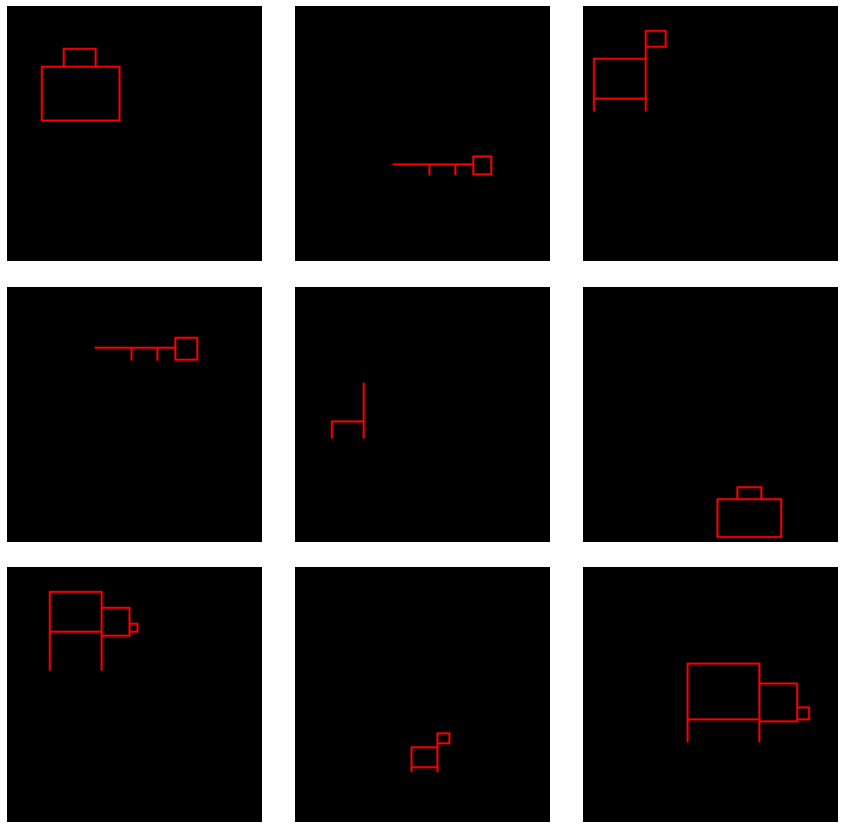

In [22]:
plt.figure(figsize=(15,15))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot2grid((3,3), (i,j))
        tmp = get_rand_img() #Get a random drawing
        
        #Flip it vertically with p = 0.5
        if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
            
        #Get a random initial point on image plane for drawing    
        v, h = rplace(tmp)
        
        #Get the bitmap array of the image
        tmp1 = get_shape_from_coord(tmp,v=v, h=h)
        
        #Plot it
        fig = plt.imshow(tmp1)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
        
plt.savefig('examples.png')
plt.show() 

# Build convolutional autoencoder

### Libraries

In [22]:
##tensorflow###
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Environment

Function to sample a random set of images to train and test the model.

In [23]:
a= get_batch(bsize=10, ns=20)

### Plot bitmap (red channel) and reconstruction from stroke sequence (green)

Doublecheck that the input bitmap and the sequence of targets for stroke generate the same image. Bitmap is in red, reconstruction from strokes in green channel, so image should appear yellow.

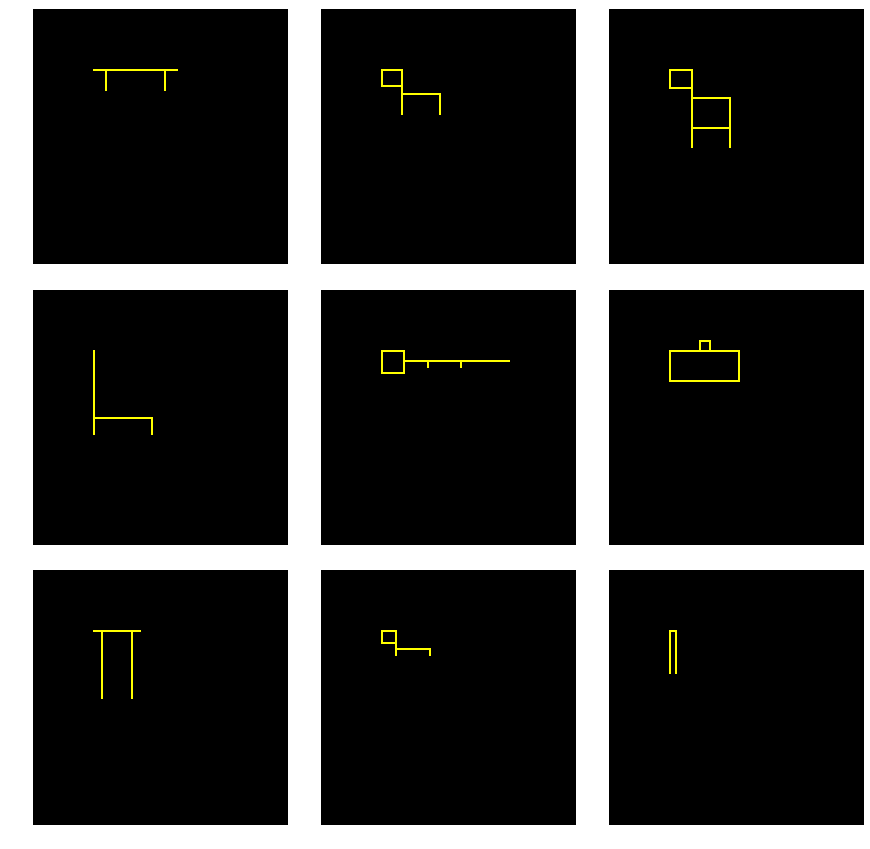

In [24]:
gsz = 3

tmp1, tmp2, tmp3 = get_batch(bsize=100)
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = np.squeeze(tmp1[indx,:,:,:])
        fr = get_shape_from_coord(np.squeeze(tmp2[indx,:,:]), v=tmp3[indx, 0], h=tmp3[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

### Build model

In [25]:
picsize = 128

input_img = Input(shape=(picsize,picsize,3))
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation = 'relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation = 'relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation = 'sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

autoencoder.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_______________________________________________

### Train model

In [ ]:
bsize = 200
ns=20
picsz=128

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
xtrn, ytrn, imloc_trn = get_batch()

#Get a batch of testing data
xtst, ytst, imloc_tst = get_batch()


In [ ]:
H = autoencoder.fit(xtrn, xtrn, epochs = 100, batch_size = 50, validation_data=(xtst, xtst))

Check model output against true image:

In [ ]:
gridsz = 3
s = np.random.choice(np.arange(0,200),gridsz * gridsz)
tmp = autoencoder.predict(xtst[s,:,:,:])
#tmp[:,:,:,1] = xtst[s,:,:,0]  ## setting one of the channels of the predicted to be the true image

origout = tmp

tmp = origout

plt.figure(figsize=(15,15))
for i in range(0,gridsz):
    for j in range(0,gridsz):
        plt.subplot2grid((gridsz,gridsz), (i,j))
        t = tmp[i*gridsz + j,:,:,:]
        fig = plt.imshow(t)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()        

In [ ]:
#Save the model to a file
autoencoder.save('.\sk2_dcnn_autoencoder.h5')

### LSTM Sketcher

In [ ]:
from tensorflow.keras.layers import TimeDistributed, LSTM, SimpleRNN, Reshape
from tensorflow.keras.models import Sequential

#Load trained model
#eas = load_model('eas_lstm.h5')

This builds the sketcher. Note that the ConvNet is "Time Distributed"; that is, there is a copy of the network for each slice of time in the sequence. To train and test the model, I give it a copy of the bitmap image as input on each time-step as well. This is sub-optimal---we really want a single ConvNet providing input to a serialized LSTM, but I haven't been able to figure out how to build that.

In [ ]:
ns = 20 #Number of strokes
picsz = 128 #Dimensions of image

eas = Sequential()

eas.add(TimeDistributed(Conv2D(8,(3,3), activation = 'relu', padding='same'), input_shape = (ns, picsz, picsz,3)))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Conv2D(16,(3,3), activation = 'relu', padding='same')))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Conv2D(32,(3,3), activation = 'relu', padding='same')))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Flatten()))

eas.add(LSTM(32, return_sequences=True))

#eas.add(TimeDistributed(Dense(8, activation='relu')))

eas.add(TimeDistributed(Dense(3, activation = 'linear')))

eas.compile(optimizer = 'adam', loss = 'mean_squared_error')

eas.summary()

Get a training and testing batch:

In [263]:
bsize = 100
ns=20
picsz=128

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
x1, ytrn, imloc_trn = get_batch(bsize)
for i in np.arange(0,ns):
    xtrn[:,i,:,:] = x1 #Copy input image to each timeslice


#Get a batch of testing data
x2, ytst, imloc_tst = get_batch(bsize)
for i in np.arange(0,ns):
    xtst[:,i,:,:] = x2 #Copy input image to each timeslice


Doublecheck that input image and image generated by target sequence are the same:

In [ ]:
gsz = 3

#tmp1, tmp2, tmp3 = get_batch(bsize=100)
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = np.squeeze(xtrn[indx,0,:,:,:])
        fr = get_shape_from_coord(np.squeeze(ytrn[indx,:,:]), v=imloc_trn[indx, 0], h=imloc_trn[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

Train model. 30 epochs with batch-size 1 works well on my machine and takes about 15 minutes to run. NB I run out of memory if I try a batch size of 50.

In [ ]:
H = eas.fit(xtrn, ytrn, epochs = 10, batch_size = 1, validation_data=(xtst, ytst))

Plot losses

In [ ]:
plt.plot(H.history['val_loss'])
plt.plot(H.history['loss'])
plt.show()

In [ ]:
#Save the model to a file
#eas.save('.\eas2_lstm.h5')

### Visualize performance

Next two blocks choose a random set of items from the testing set and shows the model (red channel) with the drawing superimposed (green channel)

In [ ]:
gsz = 3 #plotting grid size
s = np.random.choice(np.arange(0,100), gridsz * gridsz) #random selection of items
tru = xtst[s,:,:,:,:]  #get inputs from test set
loc = imloc_tst[s,:]   #Get starting locations of items

pred = eas.predict(tru) #Use model to generate sequence of outputs for each input


In [ ]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,0,:,:,:]
        fr = get_shape_from_coord(np.squeeze(pred[indx,:,:]), v=loc[indx, 0], h=loc[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        #tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

Looks pretty good! 

## Models

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import os
import copy


In [23]:
class ToTensorCustom(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        _x, _y = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        print(_x.shape)
        _x = _x.transpose((2, 0, 1))
        _y = _y.transpose((2, 0, 1))
        return ((_x,_y))
    
class sketchdata(Dataset):
    def __init__(self, _x,_y,transform=None):
        self.images=[]
        self.coordinates=[]
        
        self.transform = transform
        
        for sketch in _x:
            self.images.append(np.asarray(sketch))
        for coord in _y:
            self.coordinates.append(coord)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #return 
        images = self.images[idx]
        coordinates = self.coordinates[idx]
        
        
        if self.transform:
            images = self.transform(images)
            
            

        return images, coordinates

In [24]:
t1, t2, t3 = get_batch(100)

In [25]:
t4,t5,t6 = get_batch(100)

In [26]:
# bsize = 100
# ns=20
# picsz=128

# x1=np.zeros(shape=(1, picsz, picsz,3))
# x2=np.zeros(shape=(1, picsz, picsz,3))
# ytrn = np.zeros(shape = (1, ns,3),dtype=np.int)
# ytst = np.zeros(shape = (1, ns,3),dtype=np.int)
# imloc_trn = np.zeros(shape=(1,2),dtype=np.int)
# imloc_tst = np.zeros(shape=(1,2),dtype=np.int)


# for im_cat in range(10):
#     xt, yt,imloc_t = get_batch(bsize=100, rloc=True, not_rand=True, choose=im_cat)
#     x1 = np.vstack([x1, xt])
#     ytrn = np.vstack([ytrn, yt])
#     imloc_trn = np.vstack([imloc_trn, imloc_t])
    
# for im_cat in range(10):
#     xt, yt,imloc_t = get_batch(bsize=100, rloc=True, not_rand=True, choose=im_cat)
#     x2 = np.vstack([x2, xt])
#     ytst = np.vstack([ytst, yt])
#     imloc_tst = np.vstack([imloc_tst, imloc_t])
    
# x1=np.delete(x1,0,0)
# x2=np.delete(x2,0,0)
# ytrn = np.delete(ytrn,0,0)
# ytst = np.delete(ytst,0,0)
# imloc_trn = np.delete(imloc_trn,0,0)
# imloc_tst =np.delete(imloc_tst,0,0)


In [27]:
np.random.seed(20)
bsize = 1000
ns=20
picsz=128

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
x1, ytrn, imloc_trn = get_batch(bsize)
for i in np.arange(0,ns):
    xtrn[:,i,:,:] = x1 #Copy input image to each timeslice


#Get a batch of testing data
x2, ytst, imloc_tst = get_batch(bsize)
for i in np.arange(0,ns):
    xtst[:,i,:,:] = x2 #Copy input image to each timeslice



#a,b = gen_sketch_data(num_sketches=20)
#ytrn= torch.tensor(ytrn, dtype=torch.uint8)
traindata =  sketchdata(x1,ytrn, transform = transforms.ToTensor() )



#c,d = gen_sketch_data(num_sketches=10)
#ytst= torch.tensor(ytst, dtype=torch.uint8)
testdata =  sketchdata(x2,ytst, transform = transforms.ToTensor() )


trainloader = torch.utils.data.DataLoader(traindata, batch_size=10,shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=10,shuffle=True)


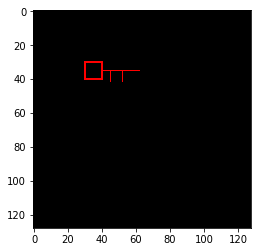

In [28]:
plt.imshow(x1[100])

## image to stroke

In [29]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size = 2):
        super(EncoderCNN, self).__init__()
        
        # get the pretrained densenet model
        self.vgg19 = models.vgg19(pretrained=True)
        
        # replace the classifier with a fully connected embedding layer
        self.vgg19.classifier = nn.Linear(in_features=25088, out_features=1024)
        
        # add another fully connected layer
        self.fc_mid = nn.Linear(in_features=1024, out_features=512)
        #self.fc_out = nn.Linear(in_features=512, out_features=256)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        
    def forward(self, images):
        
        # get the embeddings from vgg19
        x = self.dropout(self.prelu(self.vgg19(images)))
        
        # pass through the fully connected layer
        x = self.prelu(self.fc_mid(x))
        #x = self.fc_out(x)
        
        return x
    
    
    
class EncoderSimple(nn.Module):
    def __init__(self, embed_size = 2):
        super(EncoderSimple, self).__init__()
        
        self.vgg19 = models.vgg19(pretrained=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = nn.Conv2d(3,8,3)
        self.conv2 = nn.Conv2d(8,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        
        # add another fully connected layer
        self.fc_mid = nn.Linear(in_features=6272, out_features=512)
        #self.fc_out = nn.Linear(in_features=512, out_features=256)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        
    def forward(self, images):
        x = self.prelu(self.conv1(images))
        x = self.maxpool(x)
        x = self.prelu(self.conv2(x))
        x = self.maxpool(x)
        x = self.prelu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0),-1)
        
        # pass through the fully connected layer
        x = self.prelu(self.fc_mid(x))
        #x = self.fc_out(x)
        
        return x
    
    
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size=2, hidden_size=256, coord_size=3, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.coord_size = coord_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=128, hidden_size=self.hidden_size)
    
        # output fully connected layer
        self.fc_hs = nn.Linear(in_features=512, out_features=self.hidden_size)
        self.fc_rnn_inp = nn.Linear(in_features=512, out_features=128)
        self.fc_mid = nn.Linear(in_features=self.hidden_size, out_features=128, bias=True)
        self.fc_out = nn.Linear(in_features=128, out_features=self.coord_size)
    
        # embedding layer
        #self.embed = nn.Embedding(num_embeddings=self.coord_size, embedding_dim=self.embed_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    
    def forward(self,features,coordinates=[],coord_length=20, inference=False,teacher_forcing_ratio = 0):
        
        # batch size
        batch_size = features.size(0)
        
        # init the hidden and cell states to zeros
#         hidden_state = torch.zeros((batch_size, self.hidden_size)).cpu()
#         cell_state = torch.zeros((batch_size, self.hidden_size)).cpu()
        hidden_state = self.tanh(self.fc_hs(features))
        cell_state = self.tanh(self.fc_hs(features))

        
        #z = torch.cat([coordinates, features.unsqueeze(0).expand(1,coordinates.size(1), features.size(1))], 2)
    
#         print(features.size(),torch.tensor([0,0]).expand(1,2).float().size() )
        #_features = torch.cat([features, torch.tensor([0,0]).expand(batch_size,2).float()], 1)

        # embed the captions
        #captions_embed = self.embed(captions)
        
        
        if inference==False:
            # define the output tensor placeholder
            outputs = torch.empty((batch_size, coord_length, self.coord_size)).cpu()
            # pass the caption word by word
            for t in range(coord_length):
                
                teacher_force = random.random() < teacher_forcing_ratio

                # for the first time step the input is the feature vector
                if t == 0:
                    #inp = torch.tensor([0,0]).expand(batch_size,2).float()
                    inp = self.fc_rnn_inp(features)
                    hidden_state, cell_state = self.lstm_cell(inp, (hidden_state, cell_state))

                # for the 2nd+ time step, using teacher forcer
                else:
                    #feat_coords = torch.cat([features,inp],axis=1)
                    #inp = coordinates[:,t,:] if teacher_force else mid
                    inp=mid
                    hidden_state, cell_state = self.lstm_cell(inp, (hidden_state, cell_state))

                # output of the attention mechanism
                mid = self.fc_mid(hidden_state)
                out = self.fc_out(mid)

                # build the output tensor
                outputs[:, t, :] = out
        else:
            outputs = torch.empty((batch_size, coord_length, self.coord_size)).cpu()
            for t in range(coord_length):
                if t == 0:
                    inp = self.fc_rnn_inp(features)
                    hidden_state, cell_state = self.lstm_cell(inp, (hidden_state, cell_state))
                    mid = self.fc_mid(hidden_state)
                    out = self.relu(self.fc_out(mid))

                
                else:
                    #print(features.size(),out.size())
                    #feat_coords = torch.cat([features,out],axis=1)
                    hidden_state, cell_state = self.lstm_cell(mid, (hidden_state, cell_state))
                    mid = self.fc_mid(hidden_state)
                    out = self.fc_out(mid)

                # output of the attention mechanism


                # build the output tensor
                outputs[:, t, :] = out
    
        return outputs
    
    
    
class DecoderSimple(nn.Module):
    def __init__(self, coord_length=20, hidden_size=256, coord_size=3, num_layers=1):
        super(DecoderSimple, self).__init__()
        
        # define the properties
        
        self.hidden_size = hidden_size
        self.coord_size = coord_size
        self.coord_length = coord_length
        
        # lstm 
        self.rnn = nn.LSTM(512, self.hidden_size, 2, batch_first=True)
    
        # output fully connected layer
        self.fc_hs = nn.Linear(in_features=512, out_features=self.hidden_size)
        self.fc_rnn_inp = nn.Linear(in_features=512, out_features=128)
        self.fc_mid = nn.Linear(in_features=self.hidden_size, out_features=128, bias=True)
        self.fc_out = nn.Linear(in_features=128, out_features=self.coord_size)
    
        # embedding layer
        #self.embed = nn.Embedding(num_embeddings=self.coord_size, embedding_dim=self.embed_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    
    def forward(self,features,coord_length=20):
    
        
        # batch size
        batch_size = features.size(0)
        feat_dim = features.size(1)
        
        input = features.unsqueeze(1).expand(batch_size, coord_length, feat_dim)
        
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((2,batch_size,self.hidden_size)).cpu()
        cell_state = torch.zeros((2,batch_size,self.hidden_size)).cpu()
        lstm_out, (hn, cn) = self.rnn(input, (hidden_state, cell_state))
        mid = self.fc_mid(lstm_out)
        outputs =  self.fc_out(mid)
        
        return outputs
    
    

In [30]:
enc = EncoderSimple().cpu()
dec = DecoderSimple().cpu()

In [37]:
import torch.optim as optim


params = list(enc.parameters()) + list(dec.parameters())
optimizer = optim.Adam(params,weight_decay=1e-5)
criterion =  nn.MSELoss()



In [ ]:
# get the losses for vizualization
device='cpu'
losses = list()
val_losses = list()

num_epochs=40

for epoch in range(1, num_epochs+1):
    
    for i, data in enumerate(trainloader):
        
        # zero the gradients
        enc.zero_grad()
        dec.zero_grad()
        
        # set decoder and encoder into train mode
        enc.train()
        dec.train()
        
#         # Randomly sample a caption length, and sample indices with that length.
#         indices = train_data_loader.dataset.get_train_indices()
        
#         # Create and assign a batch sampler to retrieve a batch with the sampled indices.
#         new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#         train_data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, coordinates = data
        images = images.float()
        coordinates = coordinates.float()
        
        # make the captions for targets and teacher forcer
#         coordinates_target = coordinates.to(device)
#         tmp = torch.cat((torch.zeros(coordinates.size(0),1,2), coordinates), axis=1)
#         coordinates_train = tmp[:, :tmp.shape[1]-1].to(device)
        
        # Move batch of images and captions to GPU if CUDA is available.
        #images = images.to(device)
        
        # Pass the inputs through the CNN-RNN model.
        features = enc(images)
#         outputs = dec(features, coordinates_train, inference=True)
        outputs = dec(features)
        
        # Calculate the batch loss
        #loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
#         loss = criterion(outputs, coordinates_target)
        loss = criterion(outputs, coordinates)

        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the parameters in the optimizer
        optimizer.step()
        
        # - - - Validate - - -
        # turn the evaluation mode on
    for i, data in enumerate(testloader):
        with torch.no_grad():
            
            # set the evaluation mode
            enc.eval()
            dec.eval()

            # get the validation images and captions
            val_images, val_coordinates = data
            val_coordinates= val_coordinates.float()
            val_images= val_images.float()
            
            # define the captions
#             coordinates_target = val_coordinates.to(device)
#             tmp = torch.cat((torch.zeros(val_coordinates.size(0),1,2), val_coordinates), axis=1)
#             coordinates_train = tmp[:, :tmp.shape[1]-1].to(device)
        

            # Move batch of images and captions to GPU if CUDA is available.
            #val_images = val_images.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = enc(val_images)
            outputs = dec(features)

            # Calculate the batch loss.
            #val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
            #val_loss = criterion(outputs, coordinates_target)
            val_loss = criterion(outputs, val_coordinates)
            val_losses.append(val_loss.item())
        
        
        # save the losses
        np.save('losses', np.array(losses))
        np.save('val_losses', np.array(val_losses))
        
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % (epoch, num_epochs, i, len(trainloader), loss.item(), val_loss.item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        #sys.stdout.flush()
            
    # Save the weights.
#     if epoch % save_every == 0:
#         print("\nSaving the model")
#         torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pth' % epoch))
#         torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pth' % epoch))


Epoch [5/40], Step [99/100], Loss: 1.3267, Val Loss: 1.126558

Text(0.5, 1.0, 'Losses')

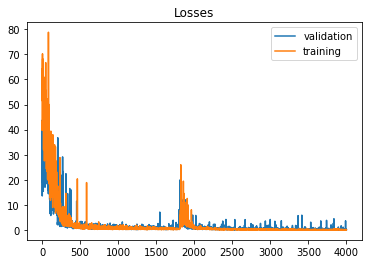

In [520]:
fig, ax = plt.subplots()
x = np.arange(len(val_losses))
y = val_losses
z = losses

ax.plot(x,y)
ax.plot(x,z)
ax.legend(['validation','training'])
#plt.plot(np.arange(len(val_losses)),val_losses, 'go--', linewidth=2, markersize=1)
plt.title('Losses')


In [521]:
np.mean(losses)

2.3180793607840315

### image to image

In [31]:
class EncoderAE(nn.Module):
    def __init__(self, embed_size = 2):
        super(EncoderAE, self).__init__()
        
        self.vgg19 = models.vgg19(pretrained=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.conv1 = nn.Conv2d(3,8,3)
        self.conv2 = nn.Conv2d(8,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        
        # add another fully connected layer
        self.fc_mid = nn.Linear(in_features=6272, out_features=512)
        #self.fc_out = nn.Linear(in_features=512, out_features=256)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        
    def forward(self, images):
        x = self.prelu(self.conv1(images))
        x, ind1 = self.maxpool(x)
        x = self.prelu(self.conv2(x))
        x, ind2 = self.maxpool(x)
        x = self.prelu(self.conv3(x))
        x, ind3 = self.maxpool(x)
        x = x.view(x.size(0),-1)
        
        # pass through the fully connected layer
        x = self.prelu(self.fc_mid(x))
        #x = self.fc_out(x)
     
        
        return x

class DecoderAE(nn.Module):
    def __init__(self):
        super(DecoderAE, self).__init__()
        
        self.fc_mid = nn.Linear(in_features=512, out_features=6272)
        self.deconv1 = nn.ConvTranspose2d(32,16,3)
        self.deconv2 = nn.ConvTranspose2d(16,8,3)
        self.deconv3 = nn.ConvTranspose2d(8,3,3)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.finalupsample = nn.Upsample(size=126, mode='nearest')
        #activation layers
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, hidden):
        
        batch_size = hidden.size(0)
        x = self.prelu(self.fc_mid(hidden))
        x = x.view(batch_size,32,14,14)
        x = self.upsample(x)
        #x = self.maxunpool(x, indices=ind[2])
        x = self.prelu(self.deconv1(x))
        x = self.upsample(x)
        #x = self.maxunpool(x,indices=ind[1])
        x = self.prelu(self.deconv2(x))
        x = self.finalupsample(x)
        #x = self.maxpool(x,indices=ind[0])
        x = self.sigmoid(self.deconv3(x))
        
        # pass through the fully connected layer
        #x = self.fc_out(x)
        
        return x
    
aeenc = EncoderAE().cpu()
aedec = DecoderAE().cpu()

In [625]:
import torch.optim as optim

params = list(aeenc.parameters()) + list(aedec.parameters())
optimizer = optim.Adam(params,weight_decay=1e-5)

criterion =  nn.BCELoss()


In [626]:
# get the losses for vizualization
device='cpu'
losses = list()
val_losses = list()

num_epochs=100

for epoch in range(1, num_epochs+1):
    
    for i, data in enumerate(trainloader):
        
        # zero the gradients
        aeenc.zero_grad()
        aedec.zero_grad()
        
        # set decoder and encoder into train mode
        aeenc.train()
        aedec.train()
        
#         # Randomly sample a caption length, and sample indices with that length.
#         indices = train_data_loader.dataset.get_train_indices()
        
#         # Create and assign a batch sampler to retrieve a batch with the sampled indices.
#         new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#         train_data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, coordinates = data
        images = images.float()
        coordinates = coordinates.float()
        
        # make the captions for targets and teacher forcer
#         coordinates_target = coordinates.to(device)
#         tmp = torch.cat((torch.zeros(coordinates.size(0),1,2), coordinates), axis=1)
#         coordinates_train = tmp[:, :tmp.shape[1]-1].to(device)
        
        # Move batch of images and captions to GPU if CUDA is available.
        #images = images.to(device)
        
        # Pass the inputs through the CNN-RNN model.
        features = aeenc(images)
#         outputs = dec(features, coordinates_train, inference=True)
        outputs = aedec(features)
        
        # Calculate the batch loss
        #loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
#         loss = criterion(outputs, coordinates_target)
        loss = criterion(outputs, images)

        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the parameters in the optimizer
        optimizer.step()
        
        # - - - Validate - - -
        # turn the evaluation mode on
    for i, data in enumerate(testloader):
        with torch.no_grad():
            
            # set the evaluation mode
            aeenc.eval()
            aedec.eval()

            # get the validation images and captions
            val_images, val_coordinates = data
            val_coordinates= val_coordinates.float()
            val_images= val_images.float()
            
            # define the captions
#             coordinates_target = val_coordinates.to(device)
#             tmp = torch.cat((torch.zeros(val_coordinates.size(0),1,2), val_coordinates), axis=1)
#             coordinates_train = tmp[:, :tmp.shape[1]-1].to(device)
        

            # Move batch of images and captions to GPU if CUDA is available.
            #val_images = val_images.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = aeenc(val_images)
            outputs = aedec(features)

            # Calculate the batch loss.
            #val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
            #val_loss = criterion(outputs, coordinates_target)
            val_loss = criterion(outputs, val_images)
            val_losses.append(val_loss.item())
        
        
        # save the losses
        #np.save('losses', np.array(losses))
        #np.save('val_losses', np.array(val_losses))
        
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % (epoch, num_epochs, i, len(trainloader), loss.item(), val_loss.item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        #sys.stdout.flush()
            
    # Save the weights.
#     if epoch % save_every == 0:
#         print("\nSaving the model")
#         torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pth' % epoch))
#         torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pth' % epoch))


Epoch [50/50], Step [99/100], Loss: 0.0012, Val Loss: 0.0052

Text(0.5, 1.0, 'Losses')

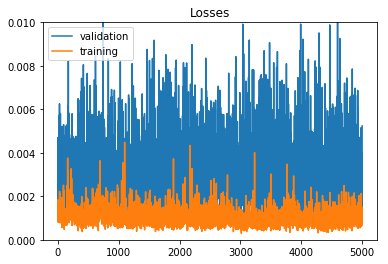

In [628]:
fig2, ax2 = plt.subplots()
x2 = np.arange(len(val_losses))
y2 = val_losses
z2 = losses

ax2.plot(x2,y2)
ax2.plot(x2,z2)
ax2.legend(['validation','training'])
ax2.set_ylim([0, 0.01])
#plt.plot(np.arange(len(val_losses)),val_losses, 'go--', linewidth=2, markersize=1)
plt.title('Losses')

In [526]:
np.mean(losses)

0.0031279713985946727

## MultiNet

In [566]:
class EncoderHybrid(nn.Module):
    def __init__(self, embed_size = 2):
        super(EncoderHybrid, self).__init__()
        
        self.vgg19 = models.vgg19(pretrained=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.conv1 = nn.Conv2d(3,8,3)
        self.conv2 = nn.Conv2d(8,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        
        # add another fully connected layer
        self.fc_mid = nn.Linear(in_features=6272, out_features=512)
        #self.fc_out = nn.Linear(in_features=512, out_features=256)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        
    def forward(self, images):
        x = self.prelu(self.conv1(images))
        x, ind1 = self.maxpool(x)
        x = self.prelu(self.conv2(x))
        x, ind2 = self.maxpool(x)
        x = self.prelu(self.conv3(x))
        x, ind3 = self.maxpool(x)
        x = x.view(x.size(0),-1)
        
        # pass through the fully connected layer
        x = self.prelu(self.fc_mid(x))
        #x = self.fc_out(x)
     
        
        return x

class DecoderHybrid(nn.Module):
    def __init__(self,coord_length=20, hidden_size=256, coord_size=3, num_layers=1):
        super(DecoderHybrid, self).__init__()
        
        # define the properties
        
        self.hidden_size = hidden_size
        self.coord_size = coord_size
        self.coord_length = coord_length
        
        # Layers
        # Autoencoder
        self.fc_mid = nn.Linear(in_features=512, out_features=6272)
        self.deconv1 = nn.ConvTranspose2d(32,16,3)
        self.deconv2 = nn.ConvTranspose2d(16,8,3)
        self.deconv3 = nn.ConvTranspose2d(8,3,3)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.finalupsample = nn.Upsample(size=126, mode='nearest')

        # Sketcher
        self.rnn = nn.LSTM(512, self.hidden_size, 2, batch_first=True)
    
        self.fc_hs = nn.Linear(in_features=512, out_features=self.hidden_size)
        self.fc_rnn_out = nn.Linear(in_features=self.hidden_size, out_features=128, bias=True)
        self.fc_out = nn.Linear(in_features=128, out_features=self.coord_size)
        # embedding layer
        #self.embed = nn.Embedding(num_embeddings=self.coord_size, embedding_dim=self.embed_size)
    
        # activations
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        
    def forward(self, features):
        coord_length = self.coord_length
        batch_size = features.size(0)
        feat_dim = features.size(1)
        input = features.unsqueeze(1).expand(batch_size, coord_length, feat_dim)
        
        x = self.prelu(self.fc_mid(features))
        x = x.view(batch_size,32,14,14)
        x = self.upsample(x)
        x = self.prelu(self.deconv1(x))
        x = self.upsample(x)
        x = self.prelu(self.deconv2(x))
        x = self.finalupsample(x)
        pixel_output = self.sigmoid(self.deconv3(x))
        
        # pass through the fully connected layer
        #x = self.fc_out(x)
        

        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((2,batch_size,self.hidden_size)).cpu()
        cell_state = torch.zeros((2,batch_size,self.hidden_size)).cpu()
        lstm_out, (hn, cn) = self.rnn(input, (hidden_state, cell_state))
        mid = self.fc_rnn_out(lstm_out)
        stroke_output =  self.fc_out(mid)
        
        return pixel_output,stroke_output
    
henc = EncoderHybrid().cpu()
hdec = DecoderHybrid().cpu()

In [567]:
hdec(henc(tru))[0].shape

torch.Size([9, 3, 128, 128])

In [568]:
hdec(henc(tru))[1].shape

torch.Size([9, 20, 3])

In [569]:
params = list(henc.parameters()) + list(hdec.parameters())
optimizer = optim.Adam(params,weight_decay=1e-5)

ae_criterion =  nn.BCELoss()
sketcher_criterion = nn.MSELoss()

In [570]:
# get the losses for vizualization
device='cpu'

ae_losses=list()
losses = list()
val_losses = list()

num_epochs=150



for epoch in range(1, num_epochs+1):
    
    for i, data in enumerate(trainloader):
        
        # zero the gradients
        henc.zero_grad()
        hdec.zero_grad()
        
        # set decoder and encoder into train mode
        henc.train()
        hdec.train()
        
        
        # Obtain the batch.
        images, coordinates = data
        images = images.float()
        coordinates = coordinates.float()
        
 
        
        # Pass the inputs through the CNN-RNN model.
        features = henc(images)

        outputs = hdec(features)
        
        # Calculate the batch loss
        #loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

        ae_loss = ae_criterion(outputs[0],images)
        sketcher_loss = sketcher_criterion(outputs[1], coordinates)
        ae_losses.append(ae_loss.item())
        
        loss = ae_loss + sketcher_loss

        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the parameters in the optimizer
        optimizer.step()
        
        # - - - Validate - - -
        # turn the evaluation mode on
    for i, data in enumerate(testloader):
        with torch.no_grad():
            
            # set the evaluation mode
            henc.eval()
            hdec.eval()

            # get the validation images and captions
            val_images, val_coordinates = data
            val_coordinates= val_coordinates.float()
            val_images= val_images.float()
            
   

            # Pass the inputs through the CNN-RNN model.
            features = henc(val_images)
            outputs = hdec(features)

            # Calculate the batch loss.
            #val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
            #val_loss = criterion(outputs, coordinates_target)
            ae_loss = ae_criterion(outputs[0],val_images)
            sketcher_loss = sketcher_criterion(outputs[1], val_coordinates)
            val_loss = ae_loss + sketcher_loss
            val_losses.append(val_loss.item())
        
       
        
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f, AE Loss: %.4f' % (epoch, num_epochs, i, len(trainloader), loss.item(), val_loss.item(),ae_loss.item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        #sys.stdout.flush()
    if(np.mean(ae_losses)<=0.00312):
            break
            
    # Save the weights.
#     if epoch % save_every == 0:
#         print("\nSaving the model")
#         torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pth' % epoch))
#         torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pth' % epoch))


Epoch [150/150], Step [99/100], Loss: 0.0598, Val Loss: 0.1744, AE Loss: 0.002788

Text(0.5, 1.0, 'Losses')

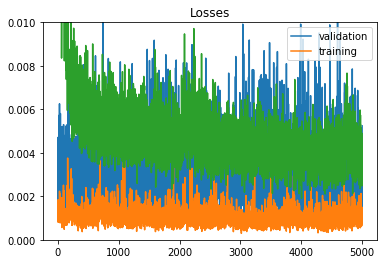

In [699]:
fig2, ax2 = plt.subplots()
x2 = np.arange(len(losses))
y2 = val_losses[0:len(losses)]
z2 = losses[0:len(losses)]
a2 = ae_losses[0:len(losses)]

ax2.plot(x2,y2)
ax2.plot(x2,z2)
ax2.plot(x2, a2)
ax2.legend(['validation','training'])
ax2.set_ylim([0, 0.01])
#plt.plot(np.arange(len(val_losses)),val_losses, 'go--', linewidth=2, markersize=1)
plt.title('Losses')

In [572]:
print(np.mean(losses))
print(np.mean(ae_losses))

1.2174847753997893
0.004134078243095428


In [1084]:
rr = False
if rr==True:
    torch.save(henc.state_dict(), '../data/henc.pth')
    torch.save(hdec.state_dict(), '../data/hdec.pth')
    torch.save(enc.state_dict(), '../data/enc.pth')
    torch.save(dec.state_dict(), '../data/dec.pth')
    torch.save(aeenc.state_dict(),'../data/aeenc.pth')
    torch.save(aedec.state_dict(),'../data/aedec.pth')

## Evaluating models

In [32]:
enc.load_state_dict(torch.load('../data/enc.pth'))
dec.load_state_dict(torch.load( '../data/dec.pth'))
aeenc.load_state_dict(torch.load('../data/aeenc.pth'))
aedec.load_state_dict(torch.load('../data/aedec.pth'))


enc.eval()
dec.eval()
aeenc.eval()
aedec.eval()


DecoderAE(
  (fc_mid): Linear(in_features=512, out_features=6272, bias=True)
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (deconv3): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
  (maxunpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (finalupsample): Upsample(size=126, mode=nearest)
  (prelu): PReLU(num_parameters=1)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [163]:
batch = next(iter(testloader))
tru = batch[0][0:9].float()
truc = batch[1][0:9]

In [164]:
#import random
gridsz = 3
gsz = 3 #plotting grid size
s = np.random.choice(np.arange(0,100), gridsz * gridsz) #random selection of items
#tru = x2[s,:,:,:]  #get inputs from test set
loc = imloc_tst[s,:]   #Get starting locations of test items
pred_sm = np.array(dec(enc(tru)).detach())
pred_ae= np.array(aedec(aeenc(tru)).detach())

#pred_hs=np.array(hdec(henc(tru))[1].detach())
#pred_hae= np.array(hdec(henc(tru))[0].detach())



In [639]:
pred_hae.shape

(9, 3, 128, 128)

In [37]:
pred_ae.shape

(9, 3, 128, 128)

## Sketcher reconstructions

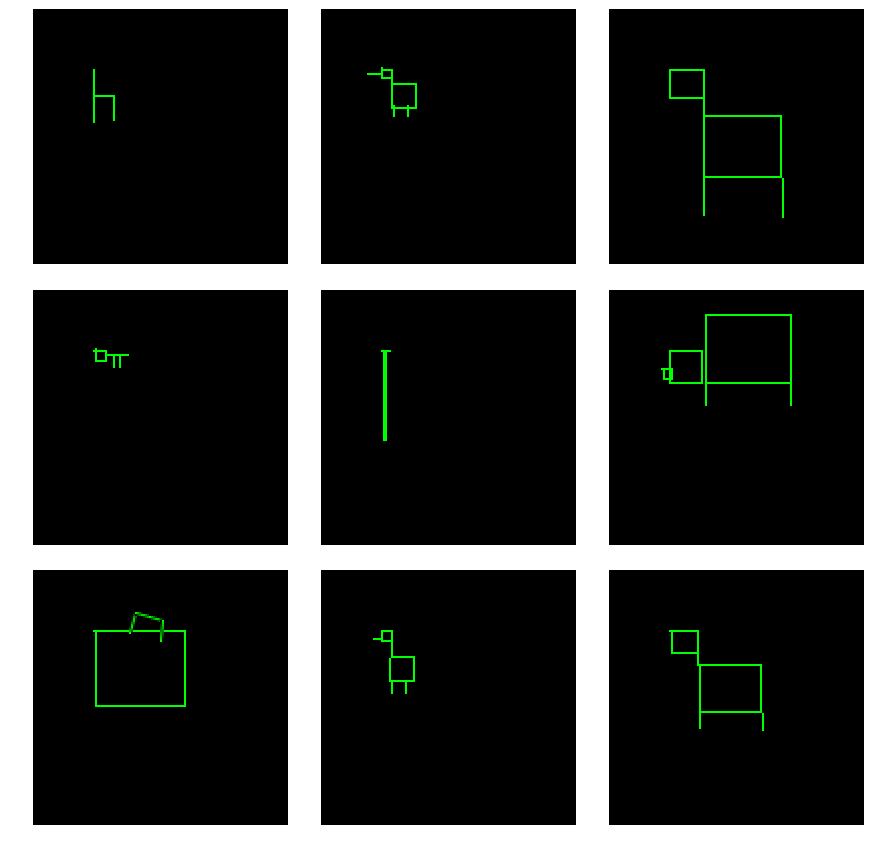

In [167]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,:,:,:].numpy().transpose((1,2,0))
        fr = get_shape_from_coord(np.squeeze(pred_sm[indx,:,:]), v=loc[indx, 0], h=loc[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

[]

## Autoencoder reconstructions

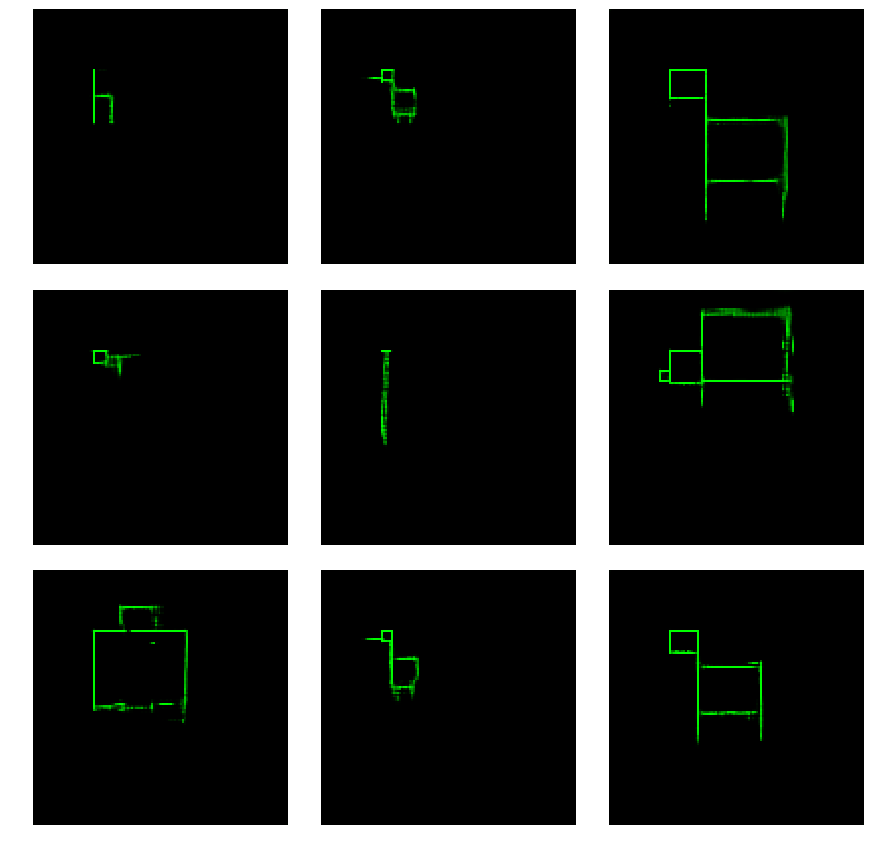

In [166]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,:,:,:].numpy().transpose((1,2,0))
        fr = pred_ae[indx,:,:,:].transpose((1,2,0))
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()     

## Hybrid model sketcher reconstructions

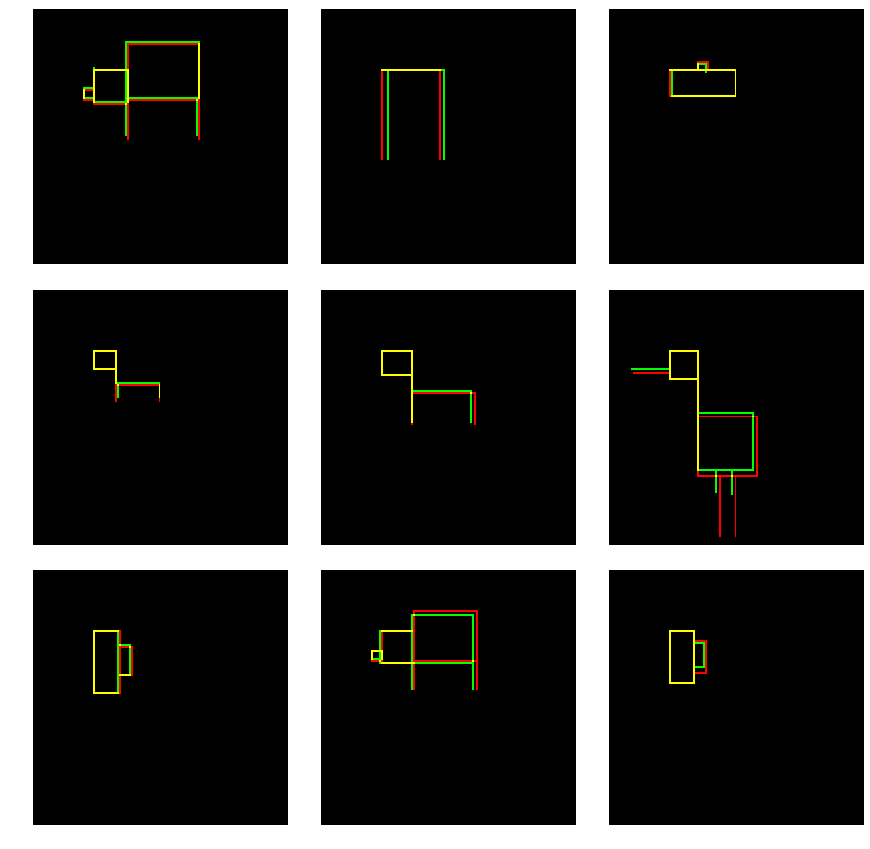

In [643]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,:,:,:].numpy().transpose((1,2,0))
        fr = get_shape_from_coord(np.squeeze(pred_hs[indx,:,:]), v=loc[indx, 0], h=loc[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

## Hybrid model bitmap reconstructions

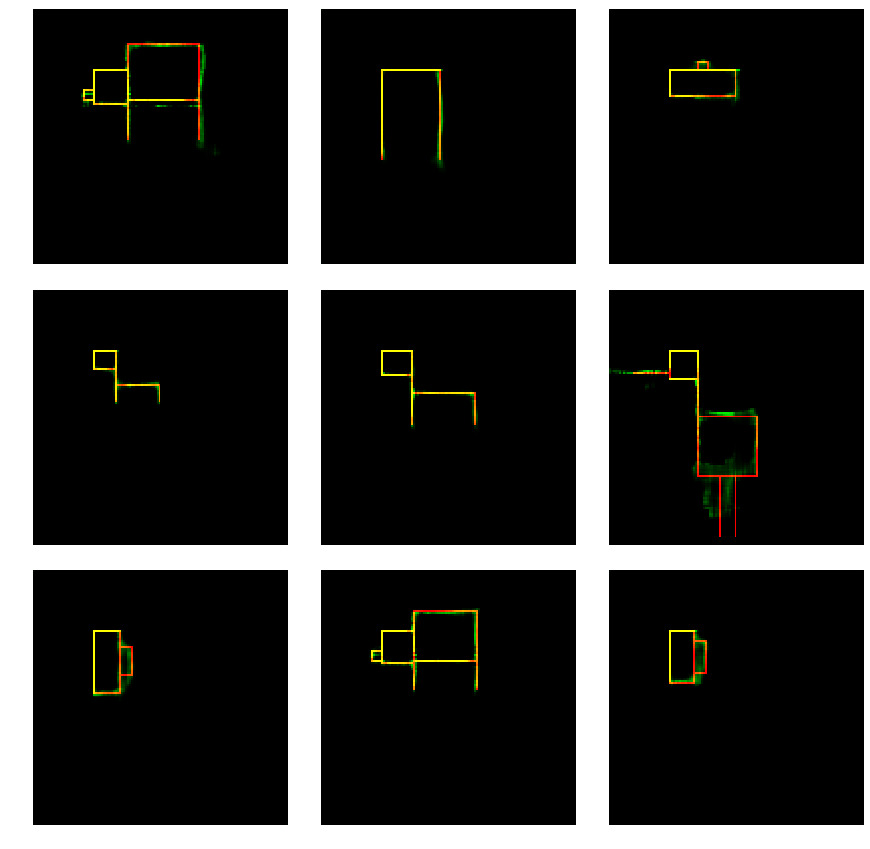

In [644]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,:,:,:].numpy().transpose((1,2,0))
        fr = pred_hae[indx,:,:,:].transpose((1,2,0))
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        #tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()      

In [390]:
a = aeenc(tru).detach()
b = enc(tru).detach()

In [461]:
np.diag(np.corrcoef(a,b))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [645]:
np.random.seed(20)

dog_ims = []
for i in range(100):
    tmp=get_rand_img(choose=6)
    if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
    v, h = rplace(tmp)
    final_im = get_shape_from_coord(tmp,v=v, h=h)
    final_im = final_im.transpose(2,0,1)
    final_im = torch.tensor(final_im).float().unsqueeze(0)
    dog_ims.append(final_im)
    
sheep_ims = []
for i in range(100):
    tmp=get_rand_img(choose=7)
    if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
    v, h = rplace(tmp)
    final_im = get_shape_from_coord(tmp,v=v, h=h)
    final_im = final_im.transpose(2,0,1)
    final_im = torch.tensor(final_im).float().unsqueeze(0)
    sheep_ims.append(final_im)
    
stool_ims = []
for i in range(100):
    tmp=get_rand_img(choose=3)
    if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
    v, h = rplace(tmp)
    final_im = get_shape_from_coord(tmp,v=v, h=h)
    final_im = final_im.transpose(2,0,1)
    final_im = torch.tensor(final_im).float().unsqueeze(0)
    stool_ims.append(final_im)
    
    
chair_ims = []
for i in range(100):
    tmp=get_rand_img(choose=2)
    if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
    v, h = rplace(tmp)
    final_im = get_shape_from_coord(tmp,v=v, h=h)
    final_im = final_im.transpose(2,0,1)
    final_im = torch.tensor(final_im).float().unsqueeze(0)
    chair_ims.append(final_im)
    
    

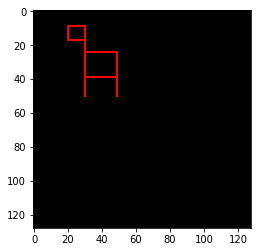

In [646]:
plt.imshow(np.array(dog_ims[0]).squeeze(0).transpose(1,2,0))

In [647]:

dog_feats_sm= np.zeros((100,512))
for i,im in enumerate(dog_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    dog_feats_sm[i,:]=a
    
    
sheep_feats_sm= np.zeros((100,512))
for i,im in enumerate(sheep_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    sheep_feats_sm[i,:]=a
    


chair_feats_sm= np.zeros((100,512))
for i,im in enumerate(chair_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    chair_feats_sm[i,:]=a
    
    
stool_feats_sm= np.zeros((100,512))
for i,im in enumerate(stool_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    stool_feats_sm[i,:]=a
    
#-----#
    
dog_feats_ae= np.zeros((100,512))
for i,im in enumerate(dog_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    dog_feats_ae[i,:]=a
    
    
sheep_feats_ae= np.zeros((100,512))
for i,im in enumerate(sheep_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    sheep_feats_ae[i,:]=a
    


chair_feats_ae= np.zeros((100,512))
for i,im in enumerate(chair_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    chair_feats_ae[i,:]=a
    
    
stool_feats_ae= np.zeros((100,512))
for i,im in enumerate(stool_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    stool_feats_ae[i,:]=a

    
    
#-----#
    
dog_feats_h= np.zeros((100,512))
for i,im in enumerate(dog_ims):
    a= np.array(henc(im).detach()).squeeze(0)
    dog_feats_h[i,:]=a
    
    
sheep_feats_h= np.zeros((100,512))
for i,im in enumerate(sheep_ims):
    a= np.array(henc(im).detach()).squeeze(0)
    sheep_feats_h[i,:]=a
    


chair_feats_h= np.zeros((100,512))
for i,im in enumerate(chair_ims):
    a= np.array(henc(im).detach()).squeeze(0)
    chair_feats_h[i,:]=a
    
    
stool_feats_h= np.zeros((100,512))
for i,im in enumerate(stool_ims):
    a= np.array(henc(im).detach()).squeeze(0)
    stool_feats_h[i,:]=a


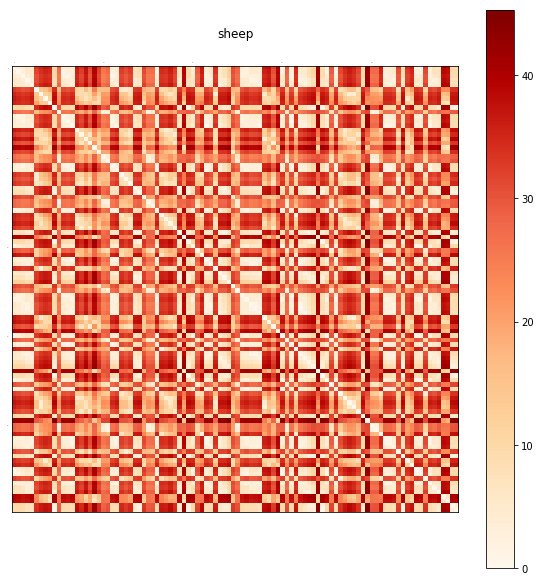

In [62]:
from scipy.spatial import distance_matrix, distance

dist = distance.pdist(sheep_feats_sm)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('sheep')
plt.show()


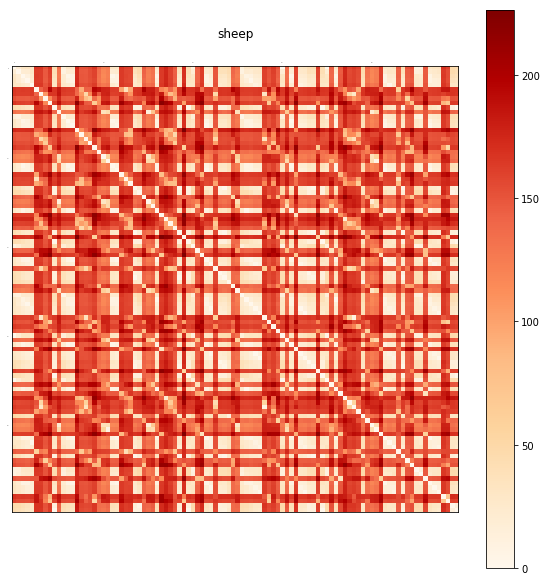

In [63]:
from scipy.spatial import distance_matrix, distance

dist = distance.pdist(sheep_feats_ae)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('sheep')
plt.show()

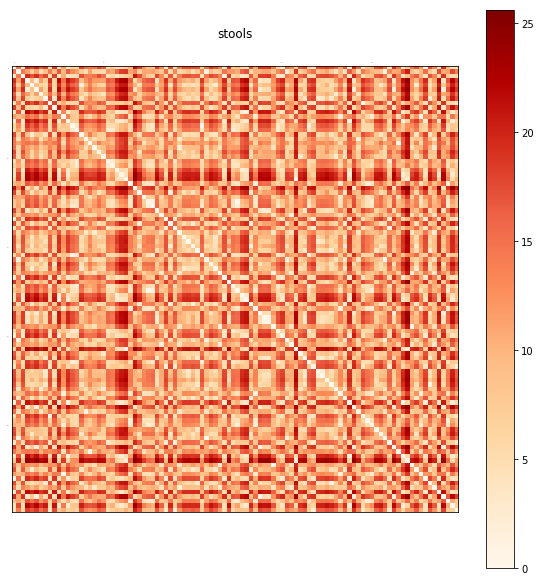

In [64]:
dist = distance.pdist(stool_feats_sm)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('stools')
plt.show()


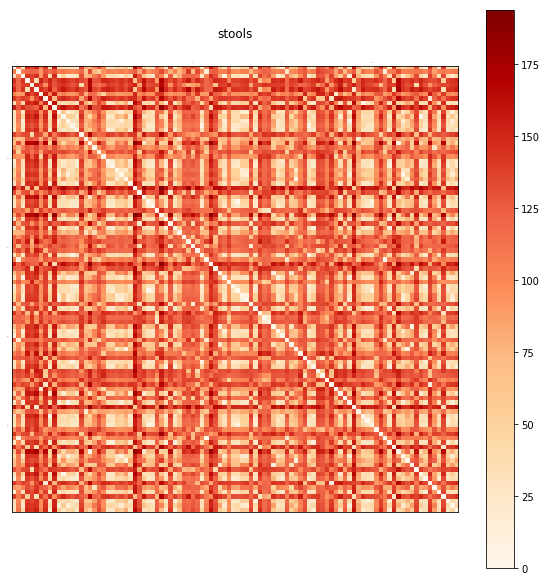

In [65]:
dist = distance.pdist(stool_feats_ae)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('stools')
plt.show()

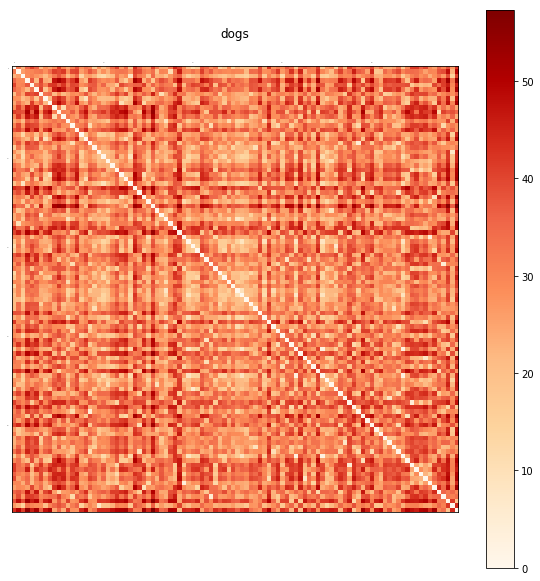

In [652]:
dist = distance.pdist(dog_feats_sm)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('dogs')
plt.show()


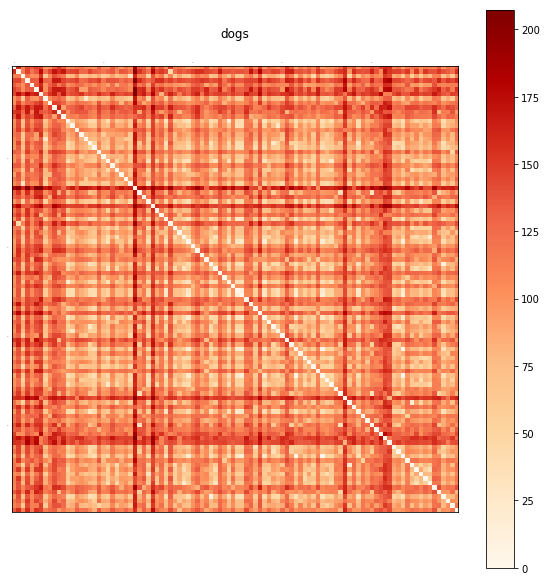

In [653]:
dist = distance.pdist(dog_feats_ae)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('dogs')
plt.show()

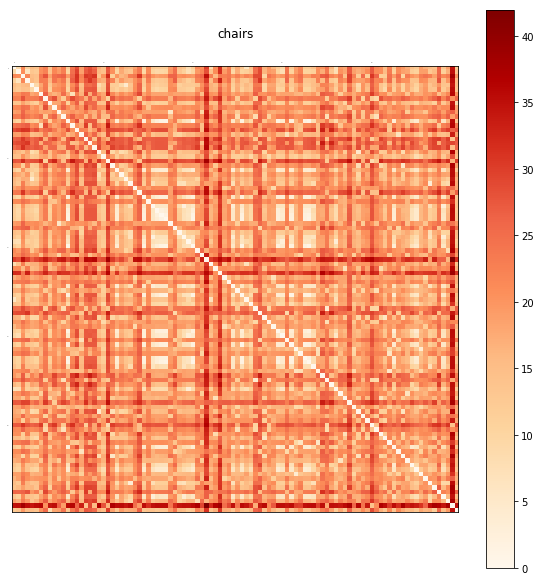

In [654]:
dist = distance.pdist(chair_feats_sm)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('chairs')
plt.show()


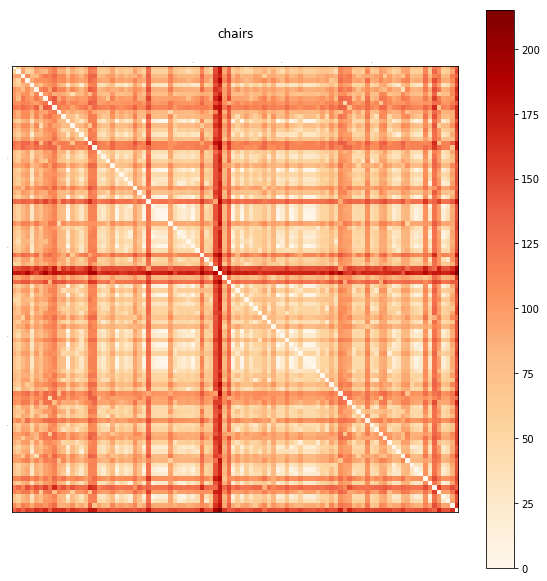

In [655]:
dist = distance.pdist(chair_feats_ae)
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
#plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
#plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar()
plt.title('chairs')
plt.show()

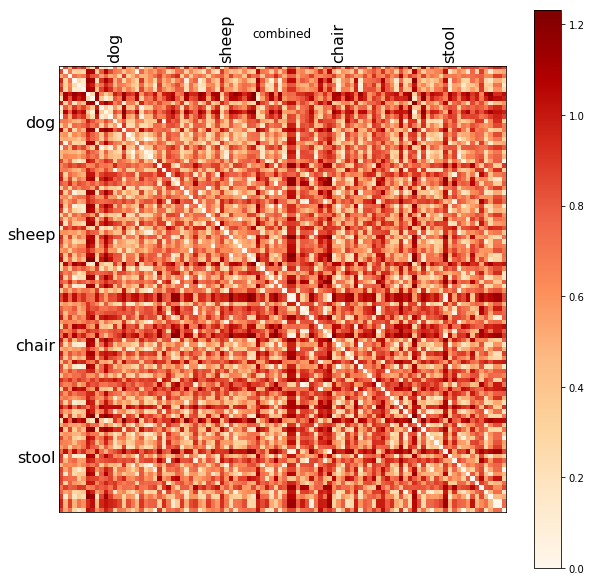

In [656]:
comb_feats = np.vstack([dog_feats_sm[np.random.choice(50,25),:],sheep_feats_sm[np.random.choice(50,25),:],chair_feats_sm[np.random.choice(50,25),:],stool_feats_sm[np.random.choice(50,25),:]])
dist = distance.pdist(comb_feats, metric= 'cosine')
dist = distance.squareform(dist)
plt.figure(figsize=(10,10))
plt.matshow(dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([12,37,62,87],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([12,37,62,87],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('combined')
plt.show()



In [657]:
all_feats_sm = np.vstack([dog_feats_sm,sheep_feats_sm,chair_feats_sm,stool_feats_sm])
all_feats_ae = np.vstack([dog_feats_ae,sheep_feats_ae,chair_feats_ae,stool_feats_ae])
all_feats_h = np.vstack([dog_feats_h,sheep_feats_h,chair_feats_h,stool_feats_h])
labs = [['dog']*100,['sheep']*100,['chair']*100,['stool']*100]
labs = [y for x in labs for y in x]

In [658]:
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import svm, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [659]:
'''
 if(i==0):
        o = mktable()
    elif(i==1):
        o = mkchair()
    elif(i==2):
        o = mkstool()
    elif(i==3):
        o = mkmug()
    elif(i==4):
        o = mkcase()
    elif(i==5):
        o = mkdog()
    elif(i==6):
        o = mksheep()
    elif(i==7):
        o = mkbird()
    elif(i==8):
        o = mkliz()
    elif(i==9):
        o = mkpig()
'''


d_ims = []
for i in range(50):
    tmp=get_rand_img(choose=1)
    if(np.random.randint(0,2)==1): 
            tmp = flipim(tmp)
    v, h = rplace(tmp)
    final_im = get_shape_from_coord(tmp,v=v, h=h)
    final_im = final_im.transpose(2,0,1)
    final_im = torch.tensor(final_im).float().unsqueeze(0)
    d_ims.append(final_im)
d_feats= np.zeros((50,512))
for i,im in enumerate(d_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    d_feats[i,:]=a

In [660]:
lr_obj = lr(multi_class ='ovr', solver='saga')
clf = svm.SVC(kernel='linear', C=1)

In [661]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_sm, labs, test_size=0.1)

In [662]:
#lr_obj.fit(feats_train, labs_train)
clf.fit(feats_train, labs_train)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [663]:
print(cross_val_score(clf, all_feats_sm, labs, cv=10))
print(clf.score(feats_test, labs_test))

[0.55  0.4   0.45  0.625 0.525 0.475 0.425 0.425 0.4   0.5  ]
0.525


In [664]:
#print(cross_val_score(lr_obj,all_feats_sm, labs, cv=10)) ### stratified by default
#print(lr_obj.score(feats_test, labs_test))

In [665]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_ae, labs, test_size=0.1)

In [666]:
#lr_obj.fit(feats_train, labs_train)
clf.fit(feats_train, labs_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [667]:
print(cross_val_score(clf, all_feats_ae, labs, cv=10))
print(clf.score(feats_test, labs_test))

[0.225 0.425 0.4   0.3   0.25  0.275 0.3   0.225 0.275 0.3  ]
0.2


In [668]:
#cross_val_score(lr_obj, all_feats_ae, labs, cv=10) ### stratified by default#
#print(lr_obj.score(feats_test, labs_test))

In [669]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_h, labs, test_size=0.1)

In [670]:
#lr_obj.fit(feats_train, labs_train)
clf.fit(feats_train, labs_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [671]:
print(cross_val_score(clf, all_feats_ae, labs, cv=10))
print(clf.score(feats_test, labs_test))

[0.225 0.425 0.4   0.3   0.25  0.275 0.3   0.225 0.275 0.3  ]
0.425


In [40]:
np.random.seed(20)
ordered_dog_ims = []
ordered_sheep_ims = []
ordered_stool_ims = []
ordered_chair_ims = []
ordered_dog_locs = []
ordered_sheep_locs= []
ordered_chair_locs= []
ordered_stool_locs= []

for reps in range(10):
    for i in range(5,10+5):
        tmp=mkdog(hd=i)
        if(np.random.randint(0,2)==1): 
                tmp = flipim(tmp)
        #v, h = rplace(tmp)
        v,h = [30,30]
        final_im = get_shape_from_coord(tmp,v=v, h=h)
        on_pix = final_im[:,:,0].sum()
        final_im = final_im.transpose(2,0,1)
        final_im = torch.tensor(final_im).float().unsqueeze(0)
        ordered_dog_ims.append(final_im)
        ordered_dog_locs.append([v,h,on_pix])



    for i in range(5,10+5):
        tmp=mksheep(hd=i)
        if(np.random.randint(0,2)==1): 
                tmp = flipim(tmp)
        #v, h = rplace(tmp)
        v,h = [30,30]
        final_im = get_shape_from_coord(tmp,v=v, h=h)
        on_pix = final_im[:,:,0].sum()
        final_im = final_im.transpose(2,0,1)
        final_im = torch.tensor(final_im).float().unsqueeze(0)
        ordered_sheep_ims.append(final_im)
        ordered_sheep_locs.append([v,h,on_pix])



    for i in range(30,30+10):
        tmp=mkstool(v=i)
        if(np.random.randint(0,2)==1): 
                tmp = flipim(tmp)
        #v, h = rplace(tmp)
        v,h = [30,30]
        final_im = get_shape_from_coord(tmp,v=v, h=h)
        on_pix = final_im[:,:,0].sum()
        final_im = final_im.transpose(2,0,1)
        final_im = torch.tensor(final_im).float().unsqueeze(0)
        ordered_stool_ims.append(final_im)
        ordered_stool_locs.append([v,h,on_pix])



    for i in range(30,30+10):
        tmp=mkchair(v=i)
        if(np.random.randint(0,2)==1): 
                tmp = flipim(tmp)
        #v, h = rplace(tmp)
        v,h = [30,30]
        final_im = get_shape_from_coord(tmp,v=v, h=h)
        on_pix = final_im[:,:,0].sum()
        final_im = final_im.transpose(2,0,1)
        final_im = torch.tensor(final_im).float().unsqueeze(0)
        ordered_chair_ims.append(final_im)
        ordered_chair_locs.append([v,h,on_pix])




In [45]:
num_ims = 100




dog_feats_sm= np.zeros((num_ims,512))
for i,im in enumerate(ordered_dog_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    dog_feats_sm[i,:]=a
    
    
sheep_feats_sm= np.zeros((num_ims,512))
for i,im in enumerate(ordered_sheep_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    sheep_feats_sm[i,:]=a
    


chair_feats_sm= np.zeros((num_ims,512))
for i,im in enumerate(ordered_chair_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    chair_feats_sm[i,:]=a
    
    
stool_feats_sm= np.zeros((num_ims,512))
for i,im in enumerate(ordered_stool_ims):
    a= np.array(enc(im).detach()).squeeze(0)
    stool_feats_sm[i,:]=a
    
#-----#
    
dog_feats_ae= np.zeros((num_ims,512))
for i,im in enumerate(ordered_dog_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    dog_feats_ae[i,:]=a
    
    
sheep_feats_ae= np.zeros((num_ims,512))
for i,im in enumerate(ordered_sheep_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    sheep_feats_ae[i,:]=a
    


chair_feats_ae= np.zeros((num_ims,512))
for i,im in enumerate(ordered_chair_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    chair_feats_ae[i,:]=a
    
    
stool_feats_ae= np.zeros((num_ims,512))
for i,im in enumerate(ordered_stool_ims):
    a= np.array(aeenc(im).detach()).squeeze(0)
    stool_feats_ae[i,:]=a
    
    
#-----#
    
# dog_feats_h= np.zeros((num_ims,512))
# for i,im in enumerate(ordered_dog_ims):
#     a= np.array(henc(im).detach()).squeeze(0)
#     dog_feats_h[i,:]=a
    
    
# sheep_feats_h= np.zeros((num_ims,512))
# for i,im in enumerate(ordered_sheep_ims):
#     a= np.array(henc(im).detach()).squeeze(0)
#     sheep_feats_h[i,:]=a
    


# chair_feats_h= np.zeros((num_ims,512))
# for i,im in enumerate(ordered_chair_ims):
#     a= np.array(henc(im).detach()).squeeze(0)
#     chair_feats_h[i,:]=a
    
    
# stool_feats_h= np.zeros((num_ims,512))
# for i,im in enumerate(ordered_stool_ims):
#     a= np.array(henc(im).detach()).squeeze(0)
#     stool_feats_h[i,:]=a

all_feats_sm = np.vstack([dog_feats_sm,sheep_feats_sm,chair_feats_sm,stool_feats_sm])
all_feats_ae = np.vstack([dog_feats_ae,sheep_feats_ae,chair_feats_ae,stool_feats_ae])
# all_feats_h = np.vstack([dog_feats_h,sheep_feats_h,chair_feats_h,stool_feats_h])


labs = [['dog']*100,['sheep']*100,['chair']*100,['stool']*100]
sizes = 40*[np.arange(10)]
labs = [y for x in labs for y in x]
sizes = [y for x in sizes for y in x]
meta = np.vstack([ordered_dog_locs,ordered_sheep_locs,ordered_chair_locs,ordered_stool_locs])

In [1068]:
clf = svm.SVC(kernel='linear', C=1)

## autoencoder

In [46]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_ae, labs, test_size=0.1)

NameError: name 'model_selection' is not defined

In [1070]:
clf.fit(feats_train, labs_train)
cv_scores = cross_val_score(clf, all_feats_ae, labs, cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )
print(clf.score(feats_test, labs_test))

[0.325 0.325 0.25  0.35  0.4   0.375 0.3   0.35  0.325 0.4  ]
mean cv score: 0.33999999999999997
0.35


## sketcher

In [1071]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_sm, labs, test_size=0.1)

In [1072]:
clf.fit(feats_train, labs_train)
cv_scores = cross_val_score(clf, all_feats_sm, labs, cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )
print(clf.score(feats_test, labs_test))

[0.625 0.625 0.525 0.575 0.625 0.675 0.475 0.625 0.5   0.5  ]
mean cv score: 0.575
0.525


## hybrid

In [1073]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    all_feats_h, labs, test_size=0.1)

In [1074]:
clf.fit(feats_train, labs_train)
cv_scores = cross_val_score(clf, all_feats_h, labs, cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )
print(clf.score(feats_test, labs_test))

[0.525 0.55  0.525 0.475 0.55  0.525 0.55  0.45  0.3   0.45 ]
mean cv score: 0.49000000000000005
0.4


In [48]:
import pandas as pd
import seaborn as sns

In [49]:

feat_cols = [ 'dim'+str(i) for i in range(all_feats_ae.shape[1]) ]
ae_df = pd.DataFrame(all_feats_ae,columns=feat_cols)
sm_df = pd.DataFrame(all_feats_sm,columns=feat_cols)
#h_df = pd.DataFrame(all_feats_h,columns=feat_cols)

ae_df['label'] = labs
ae_df['size'] = sizes


sm_df['label'] = labs
sm_df['size'] = sizes


#h_df['label'] = labs
#h_df['size'] = sizes

meta_cols = ['x','y','on_pix']
sm_df = pd.concat([sm_df, pd.DataFrame(meta, columns= meta_cols)], axis=1)
ae_df = pd.concat([ae_df, pd.DataFrame(meta, columns= meta_cols)], axis=1)
#h_df = pd.concat([h_df, pd.DataFrame(meta, columns= meta_cols)], axis=1)


In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [53]:
feats_ae = ae_df[feat_cols]
feats_sm = sm_df[feat_cols]
#feats_h = h_df[feat_cols]
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(feats_ae)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.004s...
[t-SNE] Computed neighbors for 400 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 15.399070
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.764397
[t-SNE] KL divergence after 1000 iterations: 1.297039


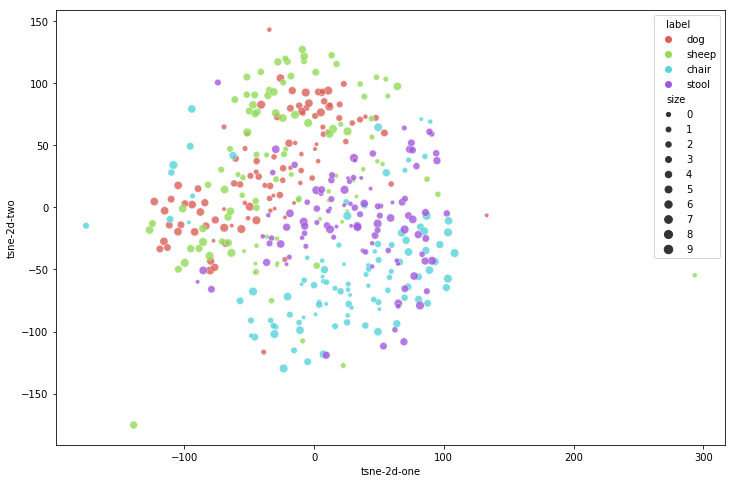

In [54]:
ae_df['tsne-2d-one'] = tsne_results[:,0]
ae_df['tsne-2d-two'] = tsne_results[:,1]
ae_df['tsne-2d-three'] = tsne_results[:,2]
plt.figure(figsize=(12,8))


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=ae_df,
    legend="full",
    alpha=0.8,
    size='size'
)

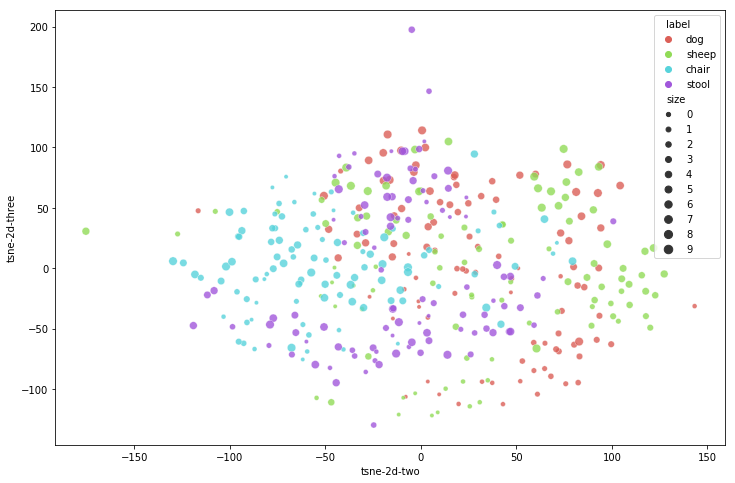

In [55]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-2d-two", y="tsne-2d-three",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=ae_df,
    legend="full",
    alpha=0.8,
    size='size'
)

In [56]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(feats_sm)

sm_df['tsne-2d-one'] = tsne_results[:,0]
sm_df['tsne-2d-two'] = tsne_results[:,1]
sm_df['tsne-2d-three'] = tsne_results[:,2]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.008s...
[t-SNE] Computed neighbors for 400 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.445004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.173424
[t-SNE] KL divergence after 1000 iterations: 1.152040


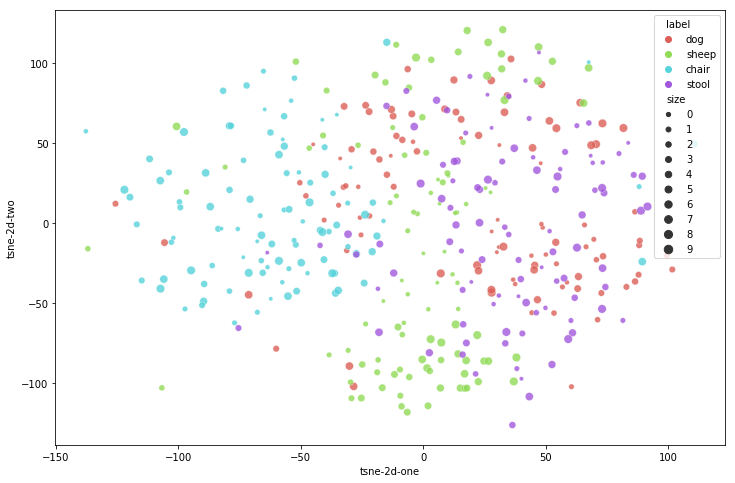

In [57]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=sm_df,
    legend="full",
    alpha=0.8,
    size='size'
)

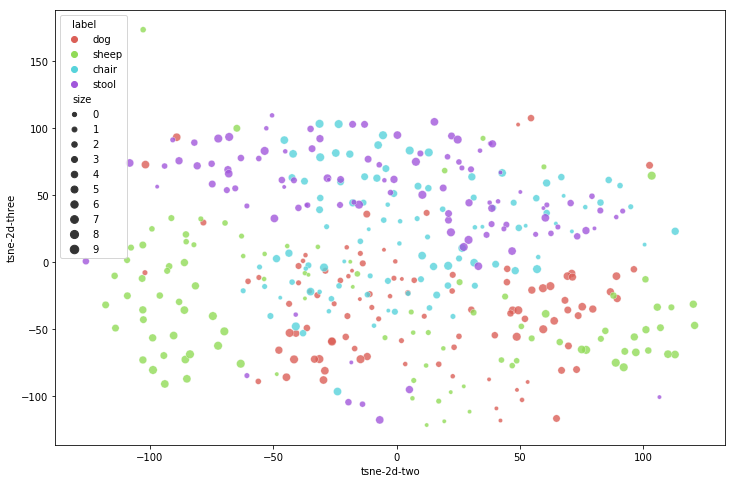

In [58]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-2d-two", y="tsne-2d-three",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=sm_df,
    legend="full",
    alpha=0.8,
    size='size'
)


In [685]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(feats_h)

h_df['tsne-2d-one'] = tsne_results[:,0]
h_df['tsne-2d-two'] = tsne_results[:,1]
h_df['tsne-2d-three'] = tsne_results[:,2]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.005s...
[t-SNE] Computed neighbors for 400 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 6.393983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.440254
[t-SNE] KL divergence after 1000 iterations: 1.401782


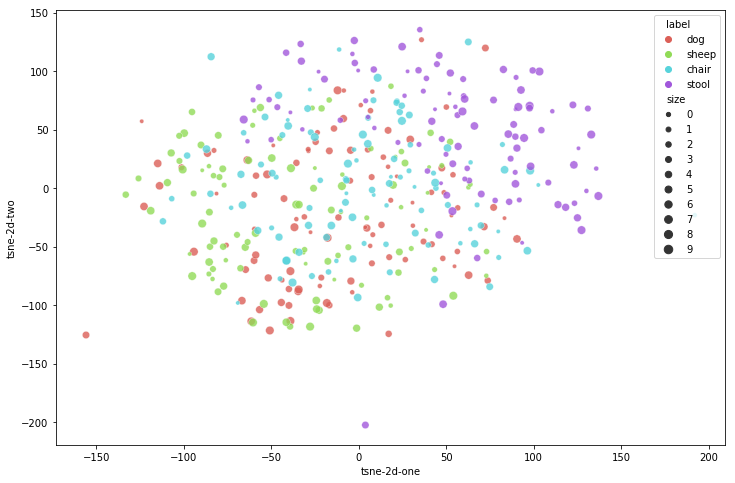

In [686]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=h_df,
    legend="full",
    alpha=0.8,
    size='size'
)

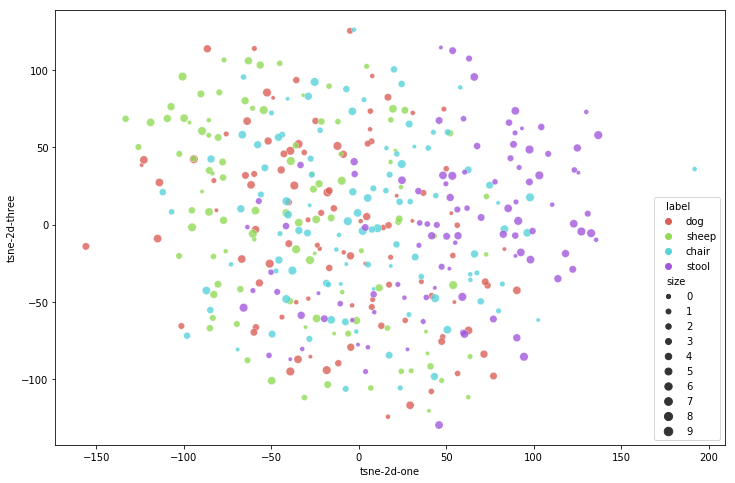

In [689]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-three",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=h_df,
    legend="full",
    alpha=0.8,
    size='size'
)

In [143]:
from mpl_toolkits.mplot3d import Axes3D

ae_df['y'] = ae_df['label'].apply(lambda x: 0 if x is 'dog' else (1 if x is 'sheep' else (2 if x is 'chair' else 3)))



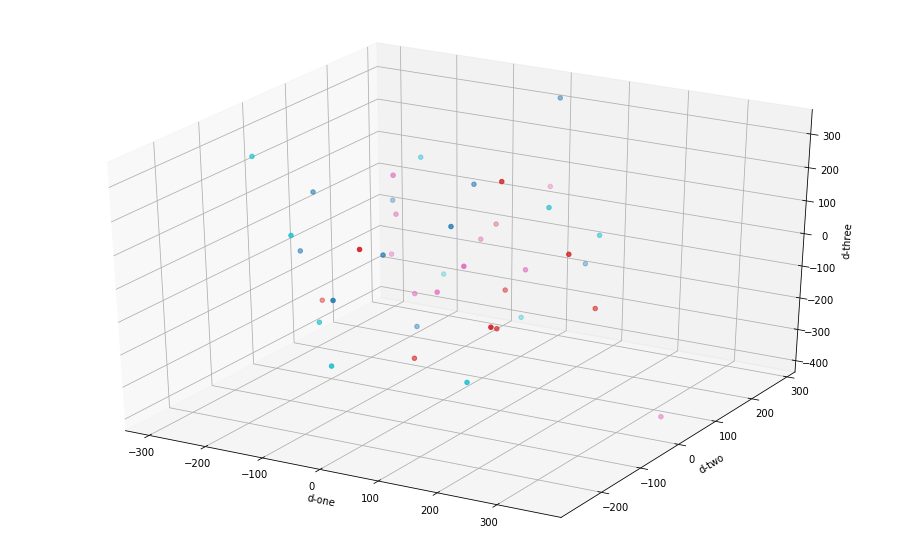

In [144]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
points = ax.scatter(
    xs=ae_df['tsne-2d-one'], 
    ys=ae_df['tsne-2d-two'], 
    zs=ae_df['tsne-2d-three'], 
    c=ae_df["y"], 
    cmap='tab10',
)
ax.set_xlabel('d-one')
ax.set_ylabel('d-two')
ax.set_zlabel('d-three')
plt.show()

In [59]:
ae_df.to_csv('../data/autoencoder_reps.csv',index=False)
sm_df.to_csv('../data/sketch_model_reps.csv',index=False)
#h_df.to_csv('../data/hybrid_model_reps.csv',index=False)

In [60]:
ae_df

dim0       dim1      dim2      dim3      dim4      dim5      dim6  \
0   -0.078297  12.227854 -0.000403 -0.000176 -0.331489 -0.121970 -0.049057   
1   -0.077991   8.593788 -0.000411 -0.000165 -0.332466 -0.138091 -0.050184   
2   -0.082803  -0.017389 -0.000458 -0.000226 -0.357732 -0.070260 -0.056588   
3   -0.033165   7.681764 -0.000162 -0.000104 -0.164134  0.875349 -0.020910   
4   -0.102454  -0.013687 -0.000491 -0.000305 -0.440375 -0.026765 -0.067869   
..        ...        ...       ...       ...       ...       ...       ...   
395 -0.030296  -0.001853 -0.000090 -0.000157 -0.221798  1.881600 -0.017046   
396 -0.060080  -0.127314 -0.000246 -0.000356 -0.421162 -0.075541 -0.036236   
397 -0.035066  -0.005750 -0.000151 -0.000236 -0.248652 -0.047031 -0.022049   
398 -0.027539  -0.002478 -0.000076 -0.000143 -0.216052  3.013702 -0.016060   
399 -0.035561  -0.023318 -0.000150 -0.000261 -0.281981 -0.000004 -0.022734   

         dim7      dim8      dim9  ...    dim510    dim511  label  size     x  \
0   -0.016277 -0.000703 -0.013273  ... -0.002222 -0.037936    dog     0  30.0   
1   -0.016263 -0.000739 -0.011821  ... -0.002345 -0.036833    dog     1  30.0   
2   -0.017252 -0.000740 -0.012873  ... -0.003161 -0.040795    dog     2  30.0   
3   -0.006609 -0.000320 -0.007899  ... -0.001513 -0.031965    dog     3  30.0   
4   -0.020426 -0.000847 -0.018482  ... -0.003364 -0.071571    dog     4  30.0   
..        ...       ...       ...  ...       ...       ...    ...   ...   ...   
395 -0.004603 -0.000216 -0.006700  ... -0.001048 -0.045566  stool     5  30.0   
396 -0.010303 -0.000390 -0.010970  ... -0.004370 -0.089456  stool     6  30.0   
397 -0.007097 -0.000309 -0.009598  ... -0.001476 -0.062143  stool     7  30.0   
398 -0.004035 -0.000189 -0.006129  ... -0.001043 -0.044437  stool     8  30.0   
399 -0.007263 -0.000335 -0.010345  ... -0.001592 -0.071178  stool     9  30.0   

        y  on_pix  tsne-2d-one  tsne-2d-two  tsne-2d-three  
0    30.0    51.0   133.114990    -6.357173      11.732045  
1    30.0    54.0   -10.535249    19.737970    -112.496460  
2    30.0    69.0   -51.632626    59.142944     -84.842087  
3    30.0    75.0   -34.200779     7.298275      14.733136  
4    30.0    85.0    22.953793    99.599831     -63.001129  
..    ...     ...          ...          ...            ...  
395  30.0    93.0     2.171948    -0.916014      98.628998  
396  30.0   104.0    75.022545    52.074318     -32.734947  
397  30.0    83.0   -36.534466   -44.336887     -94.909920  
398  30.0    95.0   -25.696999   -29.444340      52.253098  
399  30.0   103.0    69.834381   -17.740101      74.926231  

[400 rows x 520 columns]

## Shape context functions

In [701]:
import sys                 #Just in case
import cv2 #various computer vision tools
import math
from scipy.spatial.distance import cdist, cosine # distance metrics
from scipy.optimize import linear_sum_assignment # optimization functions

In [854]:
class ShapeContext(object):

    def __init__(self, nbins_r=5, nbins_theta=15, r_inner=0.1250, r_outer=2.0):
        # number of radius zones
        self.nbins_r = nbins_r
        # number of angles zones
        self.nbins_theta = nbins_theta
        # maximum and minimum radius
        self.r_inner = r_inner
        self.r_outer = r_outer

    def _hungarian(self, cost_matrix):
        """
            Here we are solving task of getting similar points from two paths
            based on their cost matrixes. 
            This algorithm has dificulty O(n^3)
            return total modification cost, indexes of matched points
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total = cost_matrix[row_ind, col_ind].sum()
        indexes = zip(row_ind.tolist(), col_ind.tolist())
        return total, indexes

    def get_points_from_img(self, image, threshold=15, simpleto=300, radius=2):
        """
            That is not very good algorithm of choosing path points, but it will work for our case.

            Idea of it is just to create grid and choose points that on this grid.
        """
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dst = cv2.Canny(image, threshold, threshold * 3, 3)

        py, px = np.gradient(image)
        # px, py gradients maps shape can be smaller then input image shape
        points = [index for index, val in np.ndenumerate(dst)
                  if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
        h, w = image.shape

        _radius = radius
        while len(points) > simpleto:
            newpoints = points
            xr = range(0, w, _radius)
            yr = range(0, h, _radius)
            for p in points:
                if p[0] not in yr and p[1] not in xr:
                    newpoints.remove(p)
                    if len(points) <= simpleto:
                        T = np.zeros((simpleto, 1))
                        for i, (y, x) in enumerate(points):
                            radians = math.atan2(py[y, x], px[y, x])
                            T[i] = radians + 2 * math.pi * (radians < 0)
                        return points, np.asmatrix(T)
            _radius += 1

        T = np.zeros((simpleto, 1))
        
        for i, (y, x) in enumerate(points):
            
            radians = math.atan2(py[y, x], px[y, x])
            
            T[i] = radians + 2 * math.pi * (radians < 0)

        return points, np.asmatrix(T)

    def _cost(self, hi, hj):
        cost = 0
        for k in range(self.nbins_theta * self.nbins_r):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k])**2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost_by_paper(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in range(p):
            for j in range(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

    def compute(self, points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points)
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [am // t_points, am % t_points]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(self.nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        norm_angle = theta_array[max_points[0], max_points[1]]
        # making angles matrix rotation invariant
        theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0

        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta))).astype(int)

        # building point descriptor based on angle and distance
        nbins = self.nbins_theta * self.nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in range(t_points):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in range(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)

        return descriptor

    def cosine_diff(self, P, Q):
        """
            Fast cosine diff.
        """
        P = P.flatten()
        Q = Q.flatten()
        assert len(P) == len(Q), 'number of descriptors should be the same'
        return cosine(P, Q)

    def diff(self, P, Q, qlength=None):
        """
            More precise but not very speed efficient diff.

            if Q is generalized shape context then it compute shape match.

            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.

        """
        result = None
        C = self.cost_by_paper(P, Q, qlength)

        result = self._hungarian(C)

        return result

    @classmethod
    def tests(cls):
        # basics tests to see that all algorithm invariants options are working fine
        self = cls()

        def test_move():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # +30 by x
            p2 = np.array([
                [0, 130],
                [200, 90],
                [350, 250],
                [370, 130],
                [70, 330]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Moving points in 2d space should give same shape context vector"

        def test_scale():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # 2x scaling
            p2 = np.array([
                [0, 200],
                [400, 120],
                [700, 440],
                [740, 200],
                [149, 600]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Scaling points in 2d space should give same shape context vector"

        def test_rotation():
            p1 = np.array(
                [(144, 196), (220, 216), (330, 208)]
            )
            # 90 degree rotation
            theta = np.radians(90)
            c, s = np.cos(theta), np.sin(theta)
            R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            p2 = np.dot(p1, R).tolist()

            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Rotating points in 2d space should give same shape context vector"

        test_move()
        test_scale()
        test_rotation()
        print ('Tests PASSED')


ShapeContext.tests()


Tests PASSED


In [870]:
sc = ShapeContext()
def plot_sc(img, img2, rotate=False):
    sc = ShapeContext()
    sampls = 35

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    print (P[0])
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q)
    
    lines = []
    for p,q in indexes:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))
        
    fig = plt.figure(figsize=(20,10))
    #ax = plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go', x2,y2, 'ro')
    
    #ax = plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go',x2,y2,'ro')
    for p1,p2 in lines:   
        plt.gca().invert_yaxis()
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
    plt.show()
    print ("Cosine diff:", cosine(P.flatten(), Q.flatten()))
    print ("Standard diff:", standard_cost)

  

### Compute SC distance matrix

In [71]:
def tensor_to_np(image):
    npim = np.array(image).squeeze(0).transpose(1,2,0)
    npim = (npim*255).astype(np.uint8)
    return npim

In [68]:
all_ims = ordered_dog_ims+ ordered_sheep_ims+  ordered_chair_ims+ ordered_stool_ims

len(all_ims)

400

In [889]:
#sc_dist_mat = np.zeros(shape = (400,400))

for i,this_im in enumerate(all_ims):
    for j, that_im in enumerate(all_ims):
        points1, t1 = sc.get_points_from_img(tensor_to_np(this_im),simpleto=35)
        points2, t2 = sc.get_points_from_img(tensor_to_np(that_im),simpleto=35)
        P = sc.compute(points1)
        Q = sc.compute(points2)
        sc_dist_mat[i,j] = cosine(P.flatten(),Q.flatten())

In [1042]:

rr = False
if rr==True:
    with open('../data/sc_dist_mat.npy', 'wb') as f:
        np.save(f, sc_dist_mat)

In [106]:
np.load('../data/sc_dist_mat.npy')

ValueError: Cannot load file containing pickled data when allow_pickle=False

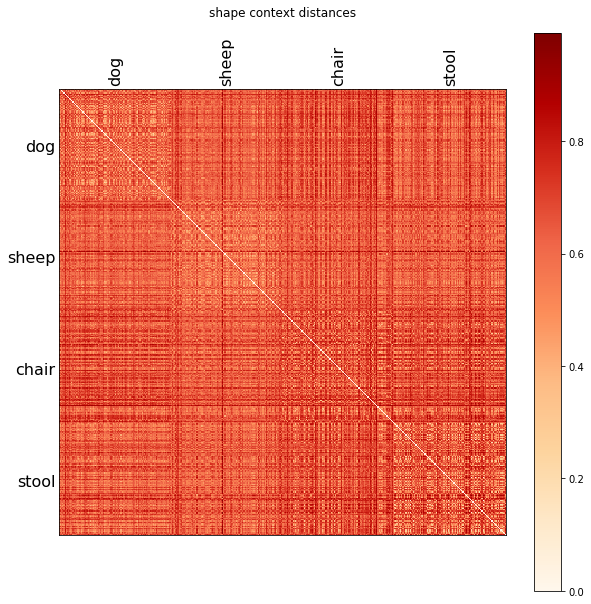

In [966]:
plt.figure(figsize=(10,10))
plt.matshow(sc_dist_mat,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('shape context distances',pad=50)
plt.show()


In [72]:
def array_then_flatten(image):
    flat_im = (tensor_to_np(image)[:,:,0]).flatten()
    return flat_im
    

In [73]:
all_ims_flat = list(map(array_then_flatten, all_ims))

In [113]:
all_ims_flat[0].sum()

13005

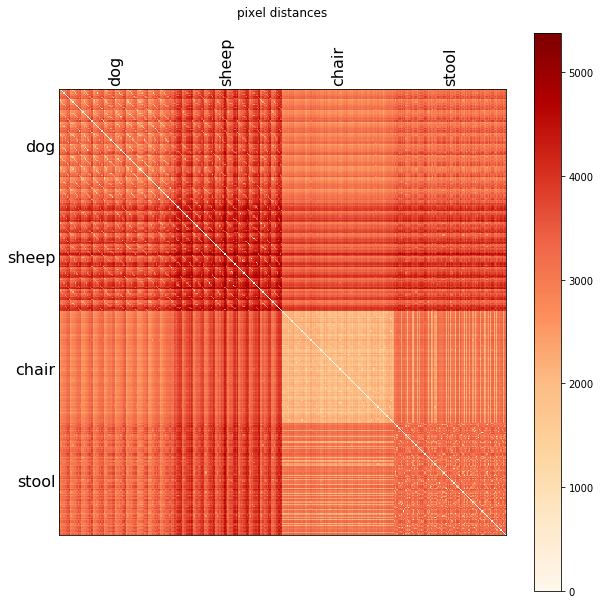

In [109]:
pix_dist = distance.pdist(all_ims_flat, metric= 'euclidean')
pix_dist = distance.squareform(pix_dist)
plt.figure(figsize=(10,10))
plt.matshow(pix_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('pixel distances',pad=50)
plt.show()

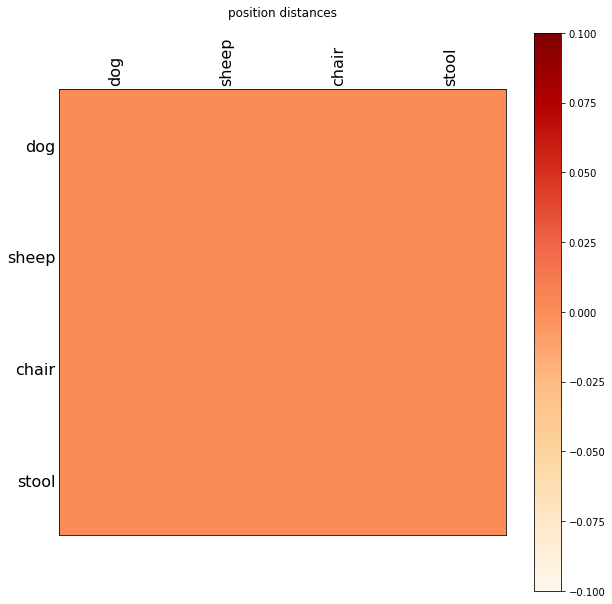

In [75]:

xy_dist = distance.pdist(meta[:,0:2], metric= 'euclidean')
xy_dist = distance.squareform(xy_dist)
plt.figure(figsize=(10,10))
plt.matshow(xy_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('position distances',pad=50)
plt.show()

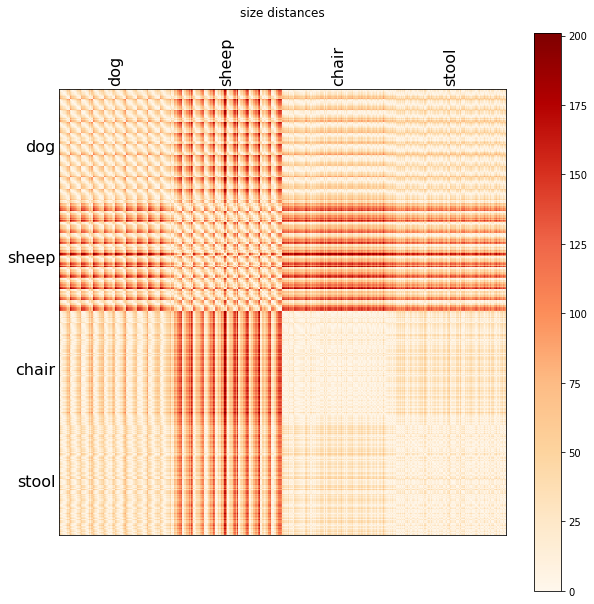

In [76]:
size_dist = distance.pdist(meta[:,2].reshape(400,1), metric= 'euclidean')
size_dist = distance.squareform(size_dist)
plt.figure(figsize=(10,10))
plt.matshow(size_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('size distances',pad=50)
plt.show()

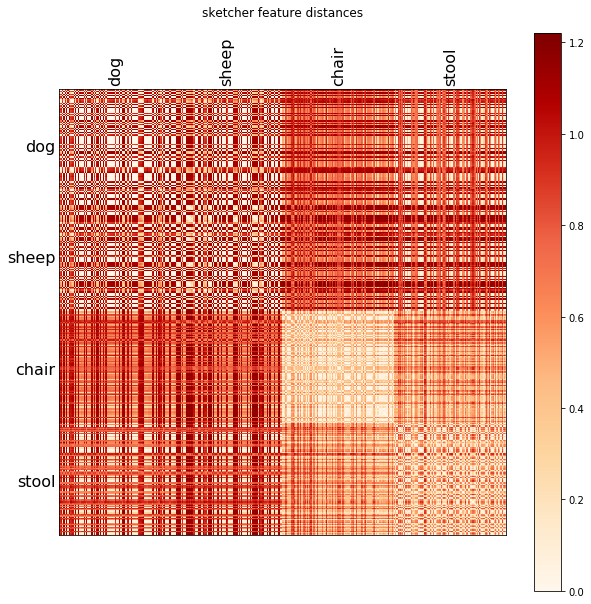

In [78]:
sm_dist = distance.pdist(all_feats_sm, metric= 'cosine')
sm_dist = distance.squareform(sm_dist)
plt.figure(figsize=(10,10))
plt.matshow(sm_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('sketcher feature distances',pad=50)
plt.show()

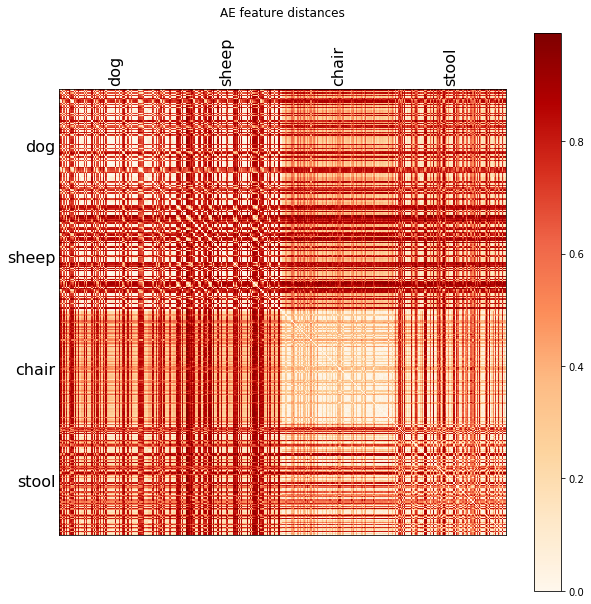

In [77]:
ae_dist = distance.pdist(all_feats_ae, metric= 'cosine')
ae_dist = distance.squareform(ae_dist)
plt.figure(figsize=(10,10))
plt.matshow(ae_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('AE feature distances',pad=50)
plt.show()

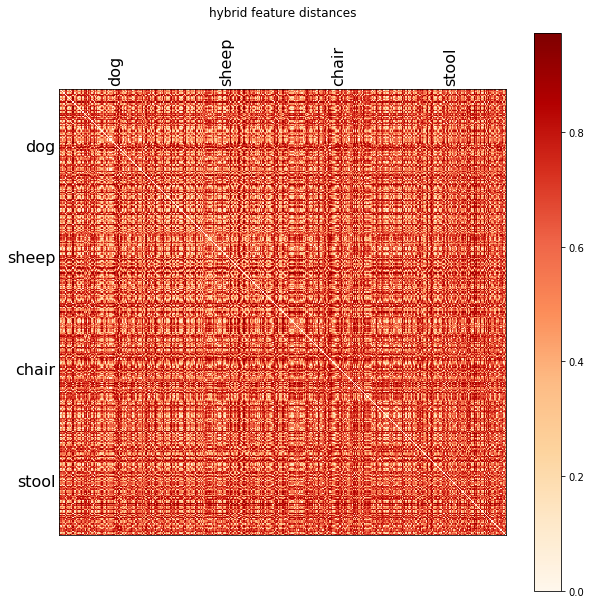

In [972]:
h_dist = distance.pdist(all_feats_h, metric= 'cosine')
h_dist = distance.squareform(h_dist)
plt.figure(figsize=(10,10))
plt.matshow(h_dist,fignum=1,cmap=plt.get_cmap('OrRd'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16, rotation=90)
plt.yticks([50,150,250,350],['dog','sheep','chair','stool'],fontsize=16,)
cb = plt.colorbar()
plt.title('hybrid feature distances',pad=50)
plt.show()

In [99]:
def get_upper_tri(matrix):
    tri_inds = np.triu_indices_from(matrix, k=1)
    u_tri = matrix[tri_inds]
    return u_tri

In [101]:
matrix_cors = np.zeros(shape=(2,4))
for i,this_fmat in enumerate([ae_dist,sm_dist]):
    for j,this_imat in enumerate([pix_dist, sc_dist_mat,xy_dist, size_dist]):
        matrix_cors[i,j] =np.corrcoef(get_upper_tri(this_fmat),get_upper_tri(this_imat))[0,1]
        

NameError: name 'sc_dist_mat' is not defined

In [1100]:
matrix_cors_df = pd.DataFrame(matrix_cors)
matrix_cors_df.index = ['ae_dist','sm_dist','h_dist']
matrix_cors_df.columns = ['pix_dist', 'sc_dist_mat','xy_dist', 'size_dist']
matrix_cors_df

pix_dist  sc_dist_mat   xy_dist  size_dist
ae_dist -0.016134    -0.009217  0.393466   0.001754
sm_dist -0.087914    -0.011553  0.486795  -0.026710
h_dist  -0.091392    -0.002009  0.447720  -0.056495

In [1259]:
sc_val_ims = []
sc_val_coords =[]
sc_val_pred_sm =[]
sc_val_pred_ae =[]
for n, data in enumerate (testloader):
    tru = data[0][0:9].float()
    pred_sm = dec(enc(tru)).detach()
    pred_ae = aedec(aeenc(tru)).detach()
    
    for t, im in enumerate(tru):
        sc_val_ims.append(im.unsqueeze(0))
        
    truc = data[1][0:9]
    for t, coord in enumerate(truc):
        sc_val_coords.append(coord.unsqueeze(0))
        
    for t, pred in enumerate(pred_sm):
        sc_val_pred_sm.append(pred.unsqueeze(0))
    for t, pred in enumerate(pred_ae):
        sc_val_pred_ae.append(pred.unsqueeze(0))
        
    
    if n>3:
        break

In [1275]:
ae_sc_losses = []
sm_sc_losses = []
for i in range(len(sc_val_ims)):
    points1, t1 = sc.get_points_from_img(tensor_to_np(sc_val_ims[i]),simpleto=35)
    points2, t2 = sc.get_points_from_img(tensor_to_np(sc_val_pred_ae[i]),simpleto=35)
    sketch_recon = (get_shape_from_coord(np.array(sc_val_pred_sm[i].squeeze(0)))*255).astype(np.uint8)
    points3, t3 = sc.get_points_from_img(sketch_recon,simpleto=35)
    P = sc.compute(points1)
    Q = sc.compute(points2)
    R = sc.compute(points3)
#     ae_sc_losses.append(cosine(P.flatten(),Q.flatten()))
#     sm_sc_losses.append(cosine(P.flatten(),R.flatten()))
    ae_sc_losses.append(sc.diff(P,Q)[0])
    sm_sc_losses.append(sc.diff(P,R)[0])

    

In [1276]:

np.mean(ae_sc_losses)


10.55448877597752

In [1280]:
np.std(ae_sc_losses)

5.184961994217571

In [1277]:
np.mean(sm_sc_losses)

13.27291565391283

In [1281]:
np.std(sm_sc_losses)

4.285856377110896

[ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 10.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  5.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


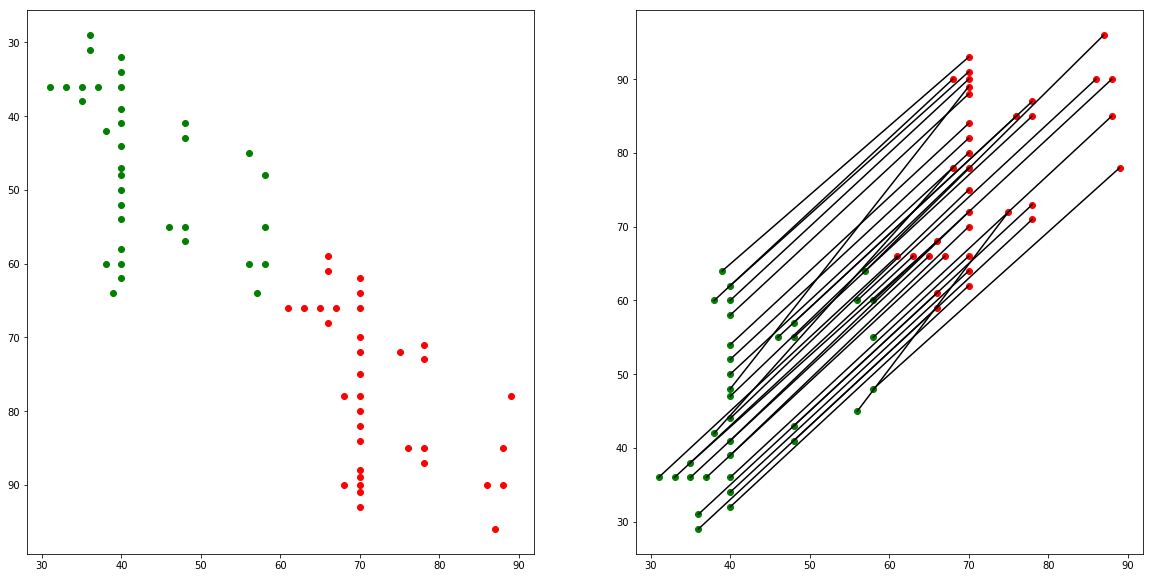

Cosine diff: 0.2626147721739026
Standard diff: 4.023334443131666


In [1264]:
plot_sc(tensor_to_np(sc_val_ims[25]),tensor_to_np(sc_val_pred_ae[25]))

[ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 10.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  5.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


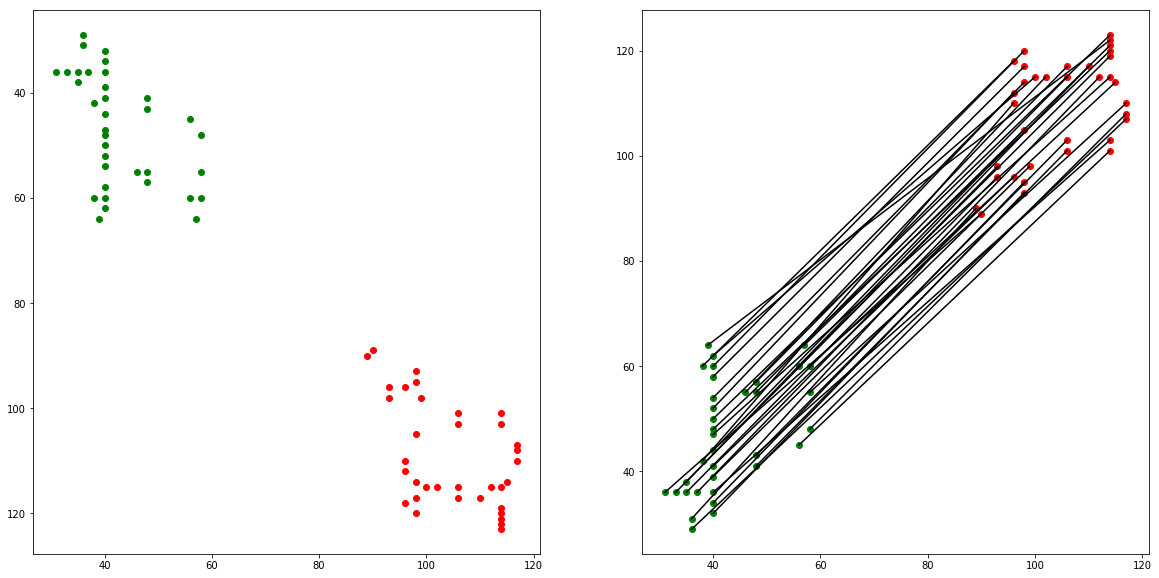

Cosine diff: 0.5151284514052896
Standard diff: 12.976377157905242


In [1265]:
plot_sc(tensor_to_np(sc_val_ims[25]),(get_shape_from_coord(np.array(sc_val_pred_sm[25].squeeze(0)))*255).astype(np.uint8))

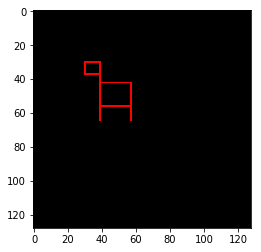

In [1266]:
plt.imshow(tensor_to_np(sc_val_ims[25]))

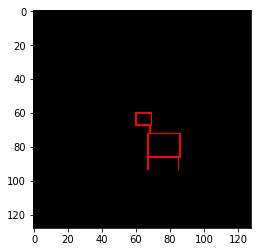

In [1273]:
plt.imshow((get_shape_from_coord(np.array(sc_val_pred_sm[25].squeeze(0)))*255).astype(np.uint8))

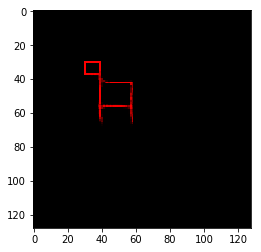

In [1274]:
plt.imshow(tensor_to_np(sc_val_pred_ae[25]))

In [1179]:
get_shape_from_coord(np.array(sc_val_pred_sm[0], v=loc[indx, 0], h=loc[indx, 1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#Plot model image and image regenerated from model output sequence
plt.figure(figsize=(15,15))
for i in range(0,gsz):
    for j in range(0,gsz):
        plt.subplot2grid((gsz,gsz), (i,j))
        indx = i * gsz + j
        tmp = tru[indx,:,:,:].numpy().transpose((1,2,0))
        fr = get_shape_from_coord(np.squeeze(pred_sm[indx,:,:]), v=loc[indx, 0], h=loc[indx, 1])
        tmp[:,:,1] = fr[:,:,0]
        
        #Uncomment next line to see just the model output drawing
        #tmp[:,:,0] = 0

        fig = plt.imshow(tmp)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

In [1173]:
pred_sm.shape

torch.Size([9, 20, 3])

In [1178]:
get_shape_from_coord(np.squeeze(pred_sm[0,:,:].detach().np.array()), v=loc[indx, 0], h=loc[indx, 1])

AttributeError: 'Tensor' object has no attribute 'np'

In [1191]:
get_shape_from_coord(np.array(sc_val_pred_sm[0].squeeze(0)))

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

(20, 3)

## MLP Classifier

In [997]:
from sklearn.neural_network import MLPClassifier

In [1075]:
mlp_clf = MLPClassifier(random_state=1, hidden_layer_sizes = (256,100),max_iter=1000)

## autoencoder

In [1076]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    ae_df[feat_cols], ae_df['label'], test_size=0.1)



In [1077]:
mlp_clf.fit(feats_train, labs_train)
print(mlp_clf.score(feats_test, labs_test))

cv_scores = cross_val_score(mlp_clf, ae_df[feat_cols], ae_df['label'], cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )

0.45
[0.425 0.5   0.3   0.425 0.275 0.3   0.3   0.4   0.4   0.325]
mean cv score: 0.365


## sketcher

In [1078]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    sm_df[feat_cols], sm_df['label'], test_size=0.1)

In [1079]:
mlp_clf.fit(feats_train, labs_train)
print(mlp_clf.score(feats_test, labs_test))
cv_scores = cross_val_score(mlp_clf, sm_df[feat_cols], sm_df['label'], cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )

0.6
[0.6   0.625 0.425 0.55  0.475 0.5   0.475 0.625 0.55  0.575]
mean cv score: 0.54


## hybrid

In [1082]:
feats_train, feats_test, labs_train, labs_test = model_selection.train_test_split(
    h_df[feat_cols], h_df['label'], test_size=0.1)

In [1083]:
mlp_clf.fit(feats_train, labs_train)
print(mlp_clf.score(feats_test, labs_test))
cv_scores = cross_val_score(mlp_clf, h_df[feat_cols], h_df['label'], cv=10)
print(cv_scores)
print("mean cv score:",np.mean(cv_scores) )

0.425
[0.575 0.6   0.5   0.425 0.475 0.4   0.35  0.5   0.5   0.525]
mean cv score: 0.485


In [866]:
cosine(P.flatten(),Q.flatten())

ValueError: operands could not be broadcast together with shapes (3375,) (2775,) 

[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 4. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


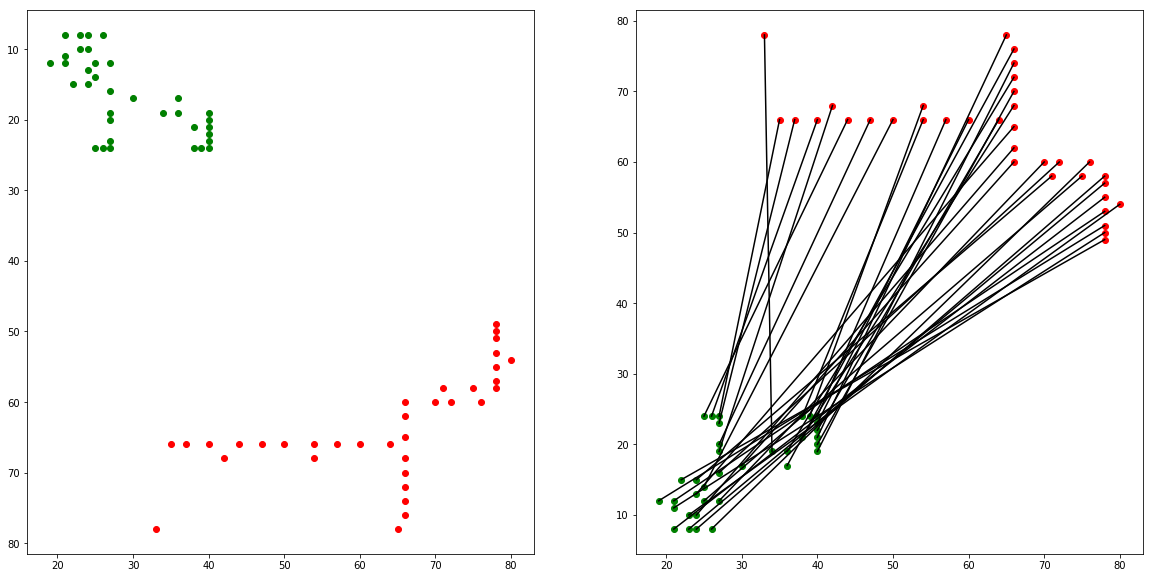

Cosine diff: 0.7228213148255149
Standard diff: 16.98080992377321


In [871]:
plot_sc(tensor_to_np(ordered_dog_ims[0]),tensor_to_np(ordered_dog_ims[6]))

[12. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  5.  5.  1.
  0.  4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


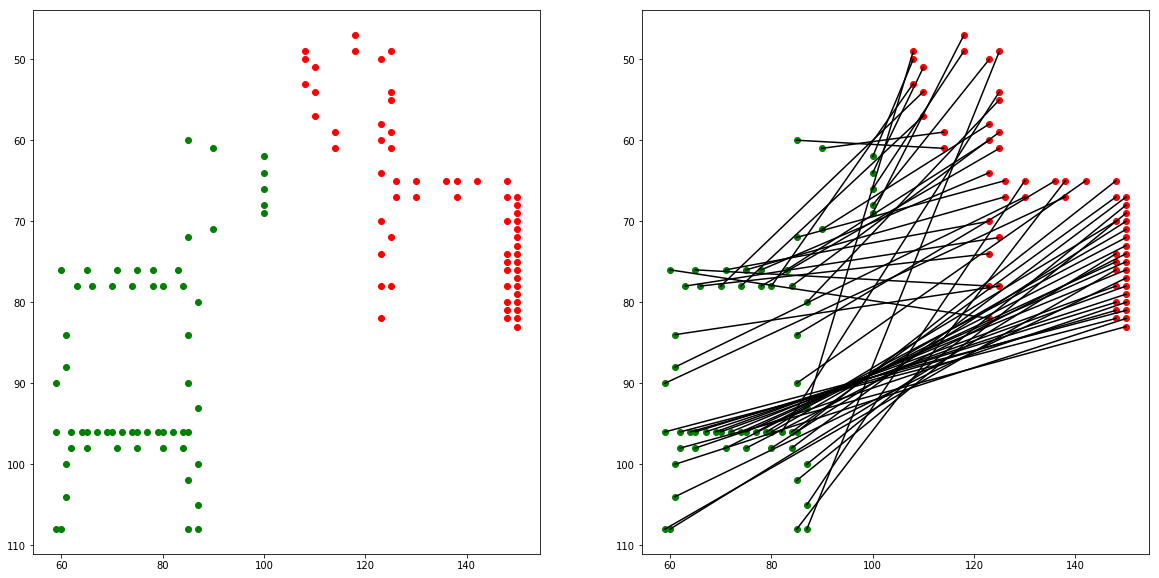

Cosine diff: 0.6126337625327666
Standard diff: 22.84037425154103


In [865]:
plot_sc(tensor_to_np(ordered_sheep_ims[5]),tensor_to_np(ordered_dog_ims[7]))

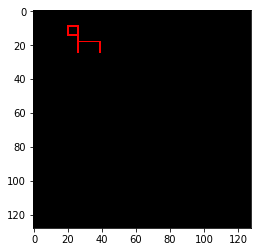

In [773]:
plt.imshow(tensor_to_np(ordered_dog_ims[0]))

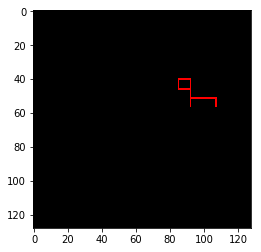

In [774]:
plt.imshow(tensor_to_np(ordered_dog_ims[1]))

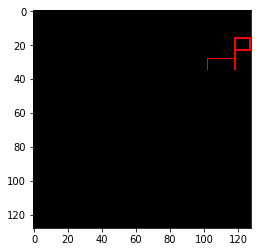

In [775]:
plt.imshow(tensor_to_np(ordered_dog_ims[2]))

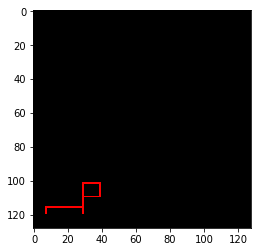

In [776]:
plt.imshow(tensor_to_np(ordered_dog_ims[3]))

### Compute pixel-wise distance matrix

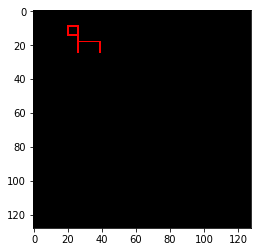

In [707]:
plt.imshow(np.array(ordered_dog_ims[0]).squeeze(0).transpose(1,2,0))

In [847]:
image = tensor_to_np(that_im)
threshold=30
simpleto=50
radius=2
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

dst = cv2.Canny(image, threshold, threshold * 3, 3)

py, px = np.gradient(image)
# px, py gradients maps shape can be smaller then input image shape
points = [index for index, val in np.ndenumerate(dst)
          if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
h, w = image.shape

_radius = radius
while len(points) > simpleto:
    newpoints = points
    xr = range(0, w, _radius)
    yr = range(0, h, _radius)
    for p in points:
        if p[0] not in yr and p[1] not in xr:
            newpoints.remove(p)
            if len(points) <= simpleto:
                T = np.zeros((simpleto, 1))
                for i, (y, x) in enumerate(points):
                    radians = math.atan2(py[y, x], px[y, x])
                    T[i] = radians + 2 * math.pi * (radians < 0)
                #return points, np.asmatrix(T)
    _radius += 1

T = np.zeros((simpleto, 1))

for i, (y, x) in enumerate(points):

    radians = math.atan2(py[y, x], px[y, x])

    T[i] = radians + 2 * math.pi * (radians < 0)

print(points)

[(43, 96), (44, 95), (45, 94), (45, 98), (46, 98), (47, 98), (48, 94), (48, 98), (49, 98), (50, 98), (51, 94), (51, 98), (52, 98), (53, 98), (54, 94), (54, 98), (55, 98), (56, 98), (57, 94), (57, 98), (58, 98), (59, 98), (60, 94), (60, 98), (61, 98), (62, 98), (63, 94), (63, 98), (64, 98), (65, 98), (66, 94), (66, 98), (67, 98), (68, 98), (69, 94), (69, 98), (70, 98), (71, 98), (72, 94), (72, 98), (73, 98), (74, 95), (74, 96), (74, 98)]


In [848]:
dst.sum()
#return points, np.asmatrix(T)

17595